# Examination of the PlantNet-300K dataset, including optimization strategies for single models, ensemble approaches and a Mixture of Experts approach

The code in this notebook examines the PLantNet-300K dataset and should be read with the main analysis pdf. This notebook contains most of the additional code for the analysis. 

The main parts of the code are cloned from this GitHub repository: https://github.com/plantnet/PlantNet-300K.

The dataset can be found here: https://zenodo.org/records/5645731#.Yuehg3ZBxPYhttps://zenodo.org/records/5645731#.Yuehg3ZBxPY

In this notebook an exploratory data analysis (EDA) is performed on the dataset. After the EDA a ResNet-18 model is trained to confirm the results of the GitHub repository and to verify the provided models. Afterwards optimization strategies for improving the performance of a single model are implemented. The notebook ends with enhancing the accuracy of the predictions by combining all 26 trained models in an averaged ensemble, weighted average ensemble weighted by the individuals models accuracy on the test set, and a Mixture of Experts approach that utilizes a router for weighing the response of the trained models dynamically based on the input image. 

All changes I made directly in the files *cli.py*, *utils.py* and *main.py* are marked by comments beginning with *# start of my additional code* and ending with *# end of my additional code*.

# Table of Contents

- [Load necessary libraries](#load_libraries)
- [Exploratory Data Analysis](#EDA)
    - [Count images per class in the image-folders train, val and test](#images_per_folder)
    - [Visualization of the total count distribution](#vis_total_distribution)
    - [Determine the data distribution by percentiles](#images_percentiles)
    - [Determine the accuracy of a single model by number of images](#images_count_accuracy)
    - [Interactive visualization of the accuracy per number of images](#vis_interactive)
    - [Average number of images per accuracy percent](#accuracy_avg_image_count)
- [Reproduction of an existing model](#recreate_model)
- [Four approaches for improving model accuracy](#optimization_approaches)
    - [Data Augmentation](#augmentation)
    - [Oversamling and Undersampling of input data](#input_sampling)
    - [Changing the Loss Function](#weighted_sampling)
    - [Continued training of an existing model](#continued_training)
- [Ensemble Method (average and weighted)](#ensemble)
- [Mixture of Experts](#mixture_of_experts)
 

# Load necessary libraries <a id="load_libraries"></a>

First the necessary libraries need to be loaded. The majority of the loaded libraries are also used in the scripts *epoch.py*, *cli.py*, *utils.py*, and *main.py*.

In [2]:
!pip install timm # not part of the standard Server configuration

import torch
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152, inception_v3, mobilenet_v2, densenet121, \
    densenet161, densenet169, densenet201, alexnet, squeezenet1_0, shufflenet_v2_x1_0, wide_resnet50_2, wide_resnet101_2,\
    vgg11, mobilenet_v3_large, mobilenet_v3_small
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import random
import timm
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import load_model, get_data
from epoch import train_epoch, val_epoch, test_epoch


# taken from utils.py get_models
pytorch_models = {'resnet18': resnet18, 'resnet34': resnet34, 'resnet50': resnet50, 'resnet101': resnet101,
                  'resnet152': resnet152, 'densenet121': densenet121, 'densenet161': densenet161,
                  'densenet169': densenet169, 'densenet201': densenet201, 'mobilenet_v2': mobilenet_v2,
                  'inception_v3': inception_v3, 'alexnet': alexnet, 'squeezenet': squeezenet1_0,
                  'shufflenet': shufflenet_v2_x1_0, 'wide_resnet50_2': wide_resnet50_2,
                  'wide_resnet101_2': wide_resnet101_2, 'vgg11': vgg11, 'mobilenet_v3_large': mobilenet_v3_large,
                  'mobilenet_v3_small': mobilenet_v3_small
                  }
timm_models = {'inception_resnet_v2', 'inception_v4', 'efficientnet_b0', 'efficientnet_b1',
               'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'vit_base_patch16_224'}

use_gpu = True

  Using cached timm-0.9.16-py3-none-any.whl (2.2 MB)


# Exploratory Data Analysis (EDA) <a id='EDA'></a>

In this chapter an Exploratory Data Analysis (EDA) is performed on the dataset. This will show the distribution of the data and subsequently it will also show the issues that can be expected in working with the dataset.

## Count images per class in the image-folders train, val and test <a id="images_per_folder"></a>

The data was provided and already split into train, val and test folders. The codeblock below defines the function that is used to count the number of images in the folders train, val and test. The goal is to first check that the data is distributed the same way per class across the folders.

In [3]:
def count_images(root_folder, pivot=True):
    data = []  
    
    # iterate through each subfolder (train, val, test)
    for folder in ['train', 'val', 'test']:
        folder_path = os.path.join(root_folder, folder)

        # iterate through each class folder inside the subfolder
        for class_id in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_id)

            # count the number of images in the class
            if os.path.isdir(class_path):
                count = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
                data.append([class_id, folder, count])

    # create a DataFrame
    df = pd.DataFrame(data, columns=['class', 'folder', 'count'])

    # pivot the DataFrame to wide format
    if pivot:
        df_pivot = df.pivot(index='class', columns='folder', values='count').reset_index()
        df_pivot.columns.name = None  # remove the name of the index
        df_pivot.columns = ['class', 'count_test', 'count_train', 'count_val']
        df_pivot['total'] = df_pivot[['count_test', 'count_train', 'count_val']].sum(axis=1)

        return df_pivot
    else:
        return df

This function is now used to count the number of images per folder. The result is saved as it is used as an intermediate result in the additionally weighted training methods later on that weigh the input based on the image count per class.

In [4]:
# create class counts DataFrame
root_folder = '../PlantNet-300K-dataset/images'
class_counts_df = count_images(root_folder, pivot=True)

# save the DataFrame to a csv file
class_counts_df.to_csv('results/class_counts.csv', index=False)
class_counts_df

class  count_test  count_train  count_val  total
0     1355868          43          335         43    421
1     1355920           1            2          1      4
2     1355932         215         1716        215   2146
3     1355936         428         3419        428   4275
4     1355937         648         5178        648   6474
...       ...         ...          ...        ...    ...
1076  1712365           1            3          1      5
1077  1713198           1            2          1      4
1078  1713199           1            5          1      7
1079  1717570           1            3          1      5
1080  1718287           1            2          1      4

[1081 rows x 5 columns]

To further compare the distribution of the categories per folder the following codeblock calculates the relative distribution per class. It was found that all classes were split according to a similar distribution (80% train, 10% val, 10% test). The distribution of the data per class across the folders appears consistent. 

In [5]:
class_counts_df['train_rel'] = class_counts_df['count_train'] / class_counts_df['total'] 
class_counts_df['val_rel'] = class_counts_df['count_val'] / class_counts_df['total'] 
class_counts_df['test_rel'] = class_counts_df['count_test'] / class_counts_df['total']

class_counts_df.sort_values(by='total', ascending=False)

class  count_test  count_train  count_val  total  train_rel   val_rel   
204   1363227         902         7208        902   9012   0.799822  0.100089  \
402   1392475         792         6337        793   7922   0.799924  0.100101   
11    1356022         767         6140        768   7675   0.800000  0.100065   
240   1364099         668         5334        668   6670   0.799700  0.100150   
4     1355937         648         5178        648   6474   0.799815  0.100093   
...       ...         ...          ...        ...    ...        ...       ...   
882   1423932           1            2          1      4   0.500000  0.250000   
881   1423633           1            2          1      4   0.500000  0.250000   
856   1420700           1            2          1      4   0.500000  0.250000   
151   1360976           1            2          1      4   0.500000  0.250000   
1080  1718287           1            2          1      4   0.500000  0.250000   

      test_rel  
204   0.100089  
402   0.099975  
11    0.099935  
240   0.100150  
4     0.100093  
...        ...  
882   0.250000  
881   0.250000  
856   0.250000  
151   0.250000  
1080  0.250000  

[1081 rows x 8 columns]

## Visualization of the total count distribution <a id="vis_total_distribution"></a>

Since the distribution was checked in the previous chapter, the following code block uses the total number of images to visualize the distribution of images per class. The X-axis label was removed because it would be unreadable with 1,081 classes. This visualization focuses on the general distribution of the data.

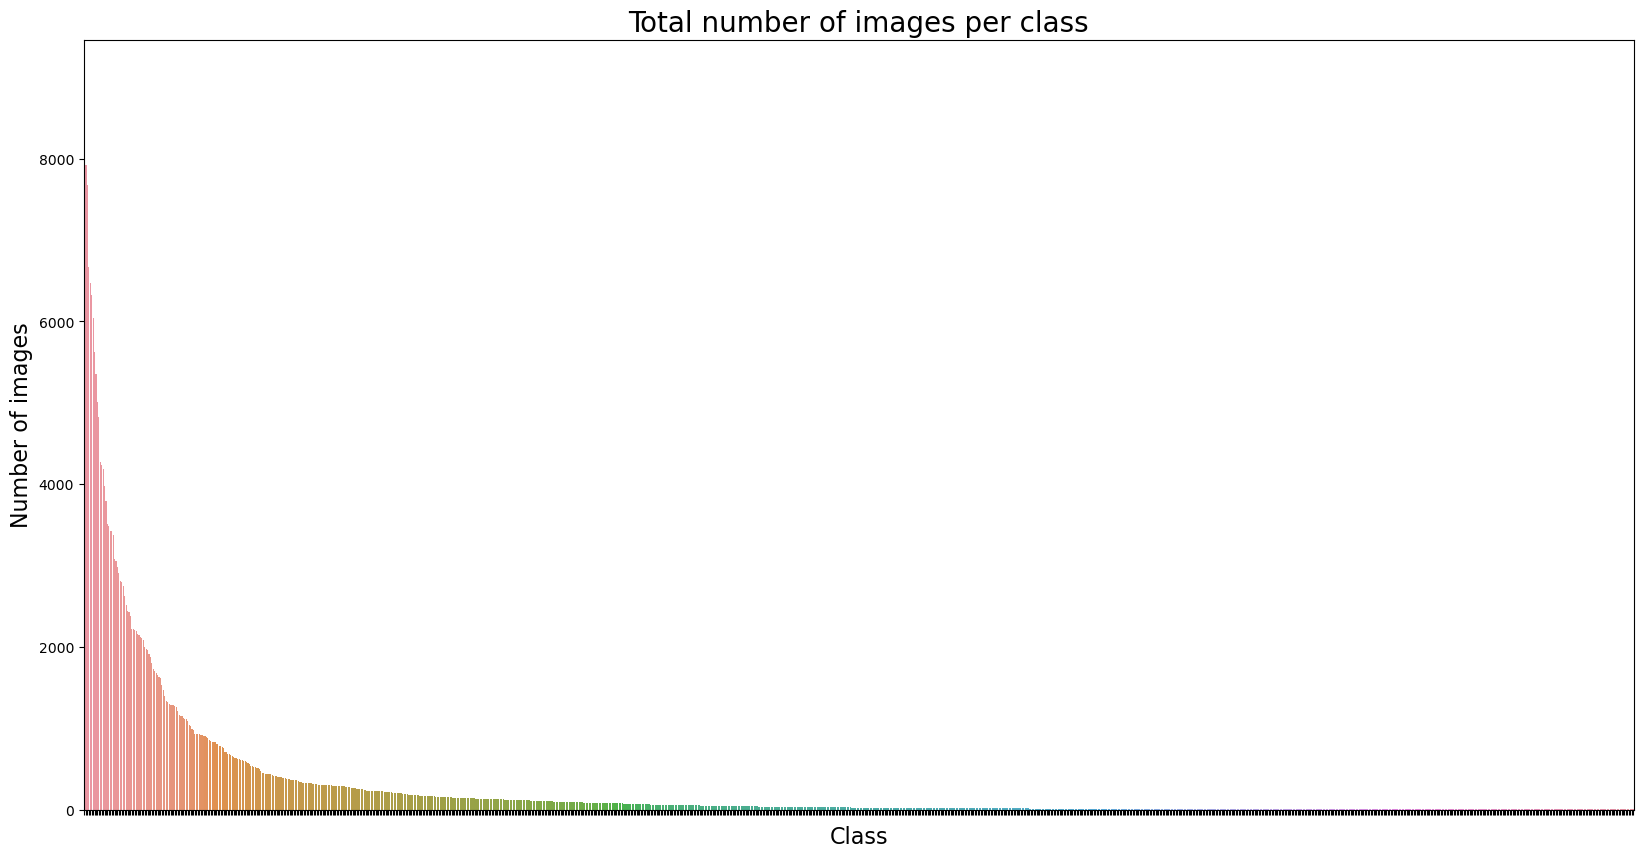

In [15]:
# sort the DataFrame by total
class_counts_df['total'] = pd.to_numeric(class_counts_df['total'])
sorted_df = class_counts_df.sort_values(by='total', ascending=False)

# extract the sorted class names to enforce the order in the plot
class_order = sorted_df['class'].tolist()

# create a sorted bar chart
plt.figure(figsize=(20, 10))
sns.barplot(x='class', y='total', data=sorted_df, order=class_order)
plt.title('Total number of images per class', fontsize=20)
plt.ylabel('Number of images', fontsize=16)
plt.xlabel('Class', fontsize=16)
plt.gca().set_xticklabels([])  # hide x-axis labels by setting them to empty strings
plt.show()

The visualization shows that the dataset is highly skewed, with a small number of classes responsible for the majority of the data.

Since there are several hundred classes that contain a relatively small amount of data, it seems likely that these classes will be difficult to recognize by the models.

## Determine the data distribution by percentiles <a id="images_percentiles"></a>

To further illustrate the level of skewness, cumulated percentiles are calculated in the following code block. This shows how many classes are included in each 10 percent percentile.

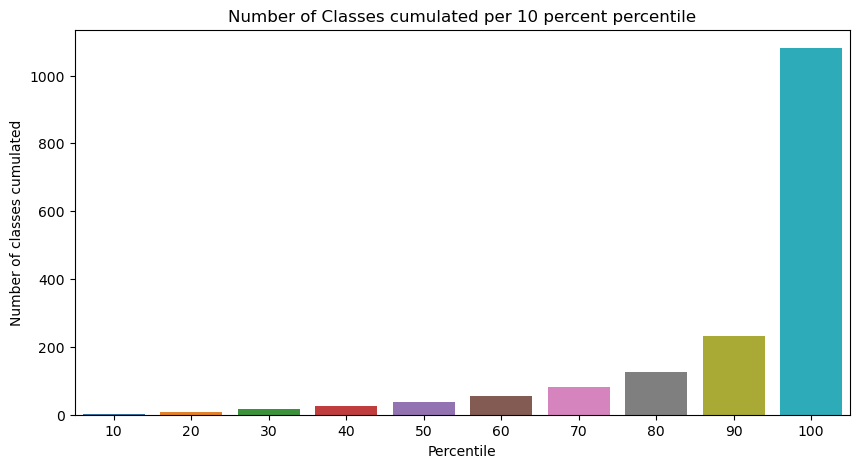

The total number of images in the dataset is: 306146


percentile  number_of_classes
0          10                  3
1          20                  9
2          30                 16
3          40                 25
4          50                 38
5          60                 54
6          70                 81
7          80                125
8          90                231
9         100               1081

In [6]:
# calculate the cumulative sum of the total column
sorted_df['cumulative_total'] = sorted_df['total'].cumsum()

# calculate the total number of images
total_images = sorted_df['total'].sum()

# calculate the cumulative percentage of the total number of images
sorted_df['cumulative_percent'] = (sorted_df['cumulative_total'] / total_images) * 100

# determine the number of classes for each percentile
percentiles_data = []
for i in range(10, 101, 10):
    number_of_classes = sorted_df[sorted_df['cumulative_percent'] <= i].shape[0]
    percentiles_data.append({'percentile': i, 'number_of_classes': number_of_classes})

# convert the percentiles data to a DataFrame
percentiles_df = pd.DataFrame(percentiles_data)

# create a sorted bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x='percentile', y='number_of_classes', data=percentiles_df)
plt.title('Number of Classes cumulated per 10 percent percentile')
plt.xlabel('Percentile')
plt.ylabel('Number of classes cumulated')
plt.show()

print(f'The total number of images in the dataset is: {total_images}')
percentiles_df

It can be seen that out of 1,081 classes, the biggest 3 classes already make up more than 10% of the dataset. More than half of the dataset consists of just the biggest 38 classes. The final 10 percent contains the smallest 850 classes.

## Determine the accuracy of a single model by number of images <a id="images_count_accuracy"></a>


The accuracy of a model in a class does not only depend on the amount of data available, but also on the quality of the data and how closely the training data and validation data correspond to the test data used. For this reason, the following code block uses the ResNet-18 model trained by PlantNet to determine the accuracy per class. The accuracy per class is then put in relation to the number of images per class.

All images must be processed in the same way. This processing is explicitly defined in the following code block via the get_data function. The values for the variables were taken from the command line call of the original GitHub repository ReadMe.

In [4]:
# define the required parameters for the function
root_folder = '../PlantNet-300K-dataset/images'
image_size = 256
crop_size = 224
batch_size = 32
num_workers = 4 # default value from cli.py
pretrained = True

# call the get_data function (from utils.py)
train_loader, val_loader, test_loader, dataset_attributes = get_data(root_folder, image_size, crop_size, batch_size, num_workers, pretrained)

# extract class_to_idx
class_to_idx = dataset_attributes['class_to_idx']

The following code block determines the performance of the ResNet-18 model trained by PlantNet. In the later ensemble methods part the accuracy for all models is determined.

In [8]:
start_time = time.time()

model_dir = './pre-trained-models'
filename = 'resnet18_weights_best_acc.tar'

model_name = filename.split('_weights_best_acc.tar')[0]
        
# load the model
model = pytorch_models[model_name](num_classes=1081)

# construct full path to model file
full_model_path = os.path.join(model_dir, filename)

# Load model weights and set to evaluation mode
load_model(model, filename=full_model_path, use_gpu=use_gpu)
model.eval()
if use_gpu and torch.cuda.is_available():
    model.cuda()

# collect softmax outputs
softmax_outputs = []
labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        if use_gpu and torch.cuda.is_available():
            inputs = inputs.cuda()

        outputs = model(inputs)
        softmax_outputs.append(outputs.cpu().numpy())
        labels.append(targets.cpu().numpy())

softmax_outputs = np.concatenate(softmax_outputs, axis=0)
labels = np.concatenate(labels, axis=0)
print(f'{filename} tested.')

# convert averaged softmax outputs to predicted classes
_, predictions = torch.max(torch.tensor(softmax_outputs), 1)

# calculate accuracy
correct = (predictions.numpy() == labels).sum()
total = labels.size
average_accuracy = correct / total

# calculate per-class accuracy
cm = confusion_matrix(labels, predictions.numpy())
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# count classes with over 90% accuracy
count_over_90 = np.sum(per_class_accuracy > 0.9)
count_under_90 = len(per_class_accuracy) - count_over_90

# print results
print(f'Accuracy for the model: {average_accuracy}')
print(f'Number of classes with accuracy over 90%: {count_over_90}')
print(f'Number of classes with accuracy under 90%: {count_under_90}')

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

resnet18_weights_best_acc.tar tested.
Average Accuracy across all models: 0.7788489347344066
Number of classes with accuracy over 90%: 93
Number of classes with accuracy under 90%: 988
total time taken: 0h 0m 48.13s


The IDs must also be mapped back to the original classes, as the number of images was determined based on the class names.

In [9]:
# map class indices back to class names
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[idx] for idx in range(len(per_class_accuracy))]

# map the accuracies to the class names
class_accuracies_mapped = dict(zip(class_names, per_class_accuracy))

# create a DataFrame from the mapped accuracies
class_accuracies_df = pd.DataFrame(list(class_accuracies_mapped.items()), columns=['class', 'accuracy'])
class_accuracies_df

class  accuracy
0     1355868  0.465116
1     1355920  0.000000
2     1355932  0.827907
3     1355936  0.862150
4     1355937  0.914110
...       ...       ...
1076  1712365  0.000000
1077  1713198  0.000000
1078  1713199  0.000000
1079  1717570  0.000000
1080  1718287  0.000000

[1081 rows x 2 columns]

The accuracy per class has now been calculated. This result is now combined with the calculated number of images per class.

In [10]:
# convert class to the same data type
class_accuracies_df['class'] = class_accuracies_df['class'].astype(int)
class_counts_df['class'] = class_counts_df['class'].astype(int)

# merge after conversion
merged_df = pd.merge(class_accuracies_df, class_counts_df, on='class', how='inner')

Based on this data the accuracy per number of images is visualized.

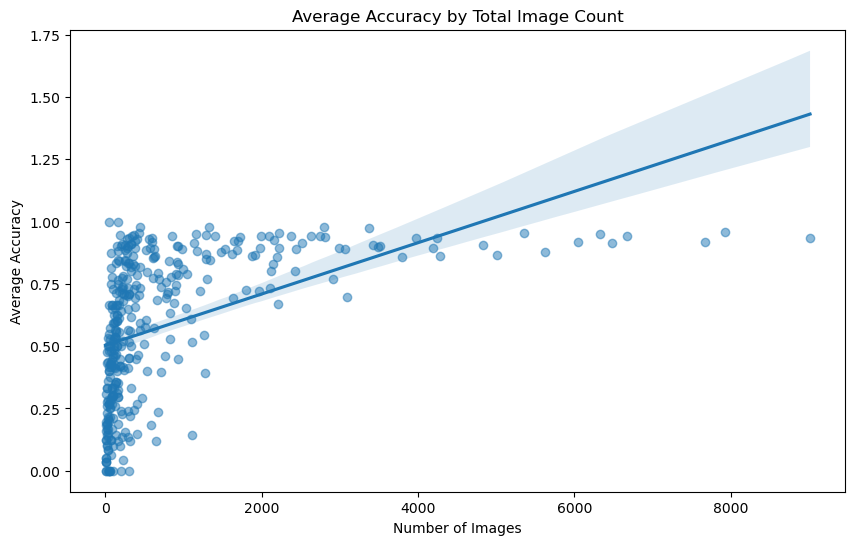

In [11]:
# group by total and calculate mean accuracy for each total count
accuracy_by_total = merged_df.groupby('total')['accuracy'].mean().reset_index()

# create the scatter plot with a trend line
plt.figure(figsize=(10, 6))
sns.regplot(x='total', y='accuracy', data=accuracy_by_total, scatter_kws={'alpha':0.5})
plt.title('Average Accuracy by Total Image Count')
plt.xlabel('Number of Images')
plt.ylabel('Average Accuracy')
plt.show()

It can be seen from the figure above that a stable accuracy result can only be seen from around 1,000 images in a class. For a closer look the code block below creates the same visualization as above, but with a focus on classes with fewer than 2,000 images.

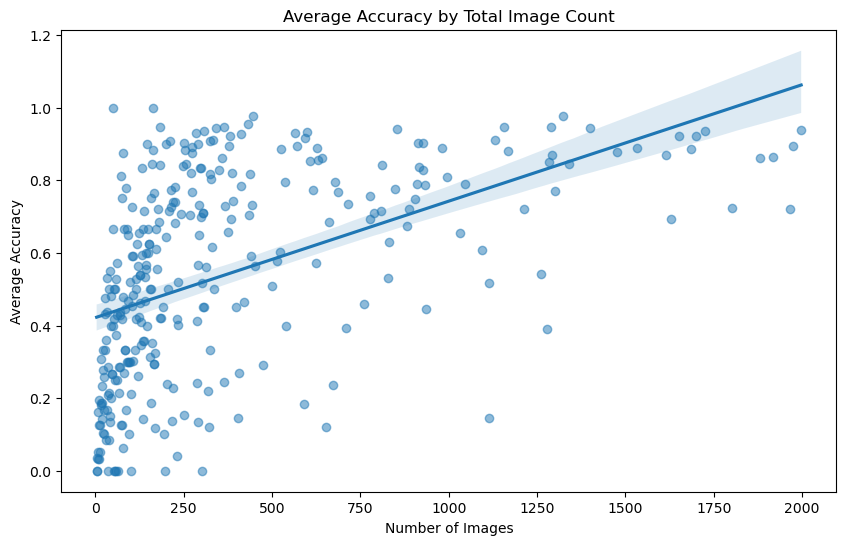

In [12]:
filtered_df = merged_df[merged_df['total'] < 2000]

# group by total and calculate mean accuracy for each total count
accuracy_by_total = filtered_df.groupby('total')['accuracy'].mean().reset_index()

# create the scatter plot with a trend line
plt.figure(figsize=(10, 6))
sns.regplot(x='total', y='accuracy', data=accuracy_by_total, scatter_kws={'alpha':0.5})
plt.title('Average Accuracy by Total Image Count')
plt.xlabel('Number of Images')
plt.ylabel('Average Accuracy')
plt.show()

## Interactive visualization of the accuracy per number of images <a id="vis_interactive"></a>

The same visualization can also be designed interactively. As displaying problems arose in integrating the interactivity with this Notebook, the interactive visualization is saved as HTML and can be opened via the saved file.

In [13]:
!pip install plotly
import plotly.express as px

# create the plot
fig = px.scatter(merged_df, x='total', y='accuracy', hover_data=['class'], title='Interactive Average Accuracy by Total Count')

# save the plot as html
fig.write_html('./results/accuracy_plot.html', auto_open=True)

## Average number of images per accuracy percent <a id="accuracy_avg_image_count"></a>

An alternative representation is the visualization as a bar chart. In addition to the visualization above, it can be deduced from this representation that an accuracy of over 90 percent is associated with over 1,000 images on average in a class.

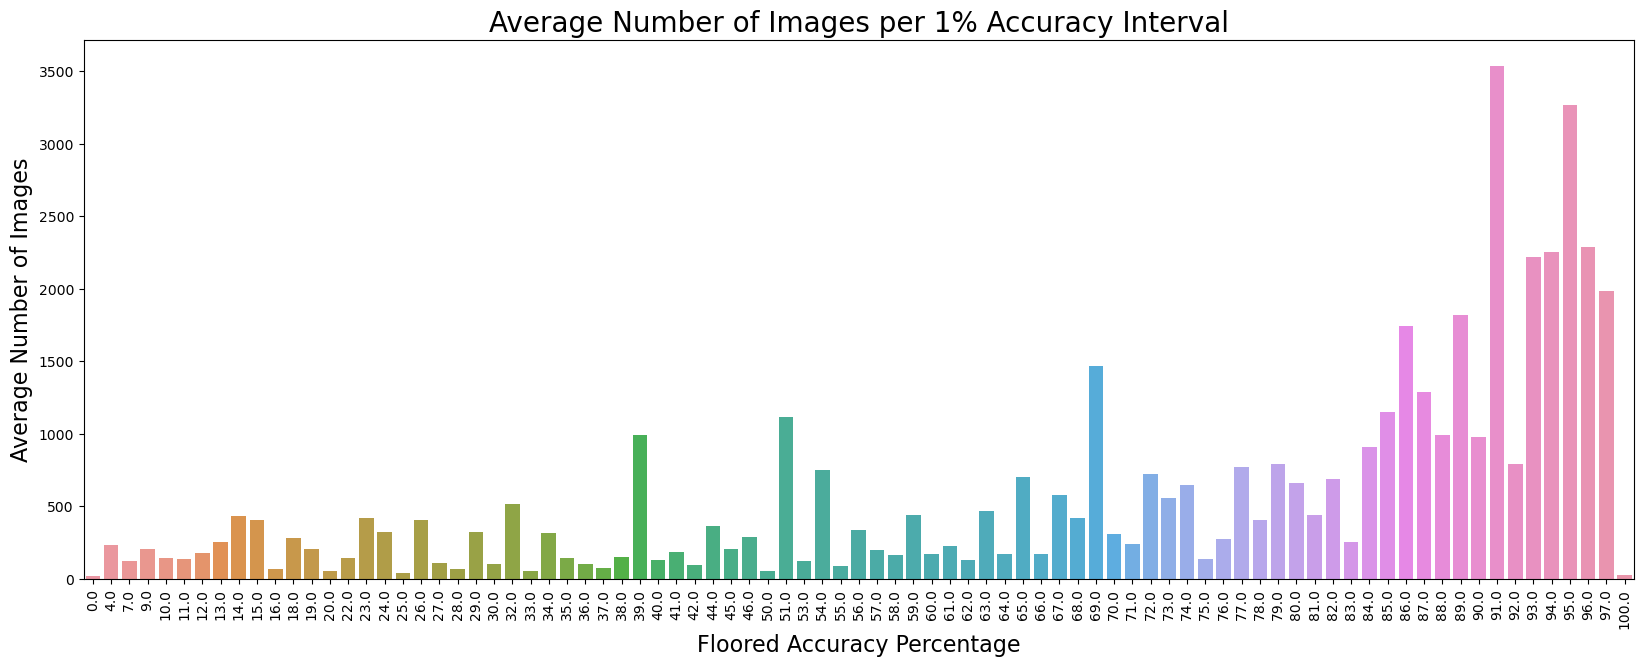

In [14]:
# floor the accuracy to the nearest whole percent
merged_df['floored_accuracy'] = np.floor(merged_df['accuracy'] * 100)

# group by the floored accuracy and calculate the average number of images
avg_images_per_accuracy = merged_df.groupby('floored_accuracy')['total'].mean().reset_index()

# rename the columns for clarity
avg_images_per_accuracy.columns = ['accuracy_percentage', 'average_number_of_images']

# create a bar plot
plt.figure(figsize=(20, 7))
sns.barplot(x='accuracy_percentage', y='average_number_of_images', data=avg_images_per_accuracy)
plt.title('Average Number of Images per 1% Accuracy Interval', fontsize=20)
plt.xlabel('Floored Accuracy Percentage', fontsize=16)
plt.ylabel('Average Number of Images', fontsize=16)
plt.xticks(rotation=90)
plt.show()

# Reproduction of an existing model <a id="recreate_model"></a>

In this chapter Plantnet's ResNet-18 model is recreated based on the information available in the GitHub repository in order to validate the initialization of the repository and to validate the provided models themselves.

Training the model took about 3 1/2 hours. One of the 4 available GPUs was used as the existing code does not utilize parallelization. It was also observed that GPU utilization was mostly in the range of about 30%. The highest utilization observed during the review was 33%. The GPU is not being fully utilized.

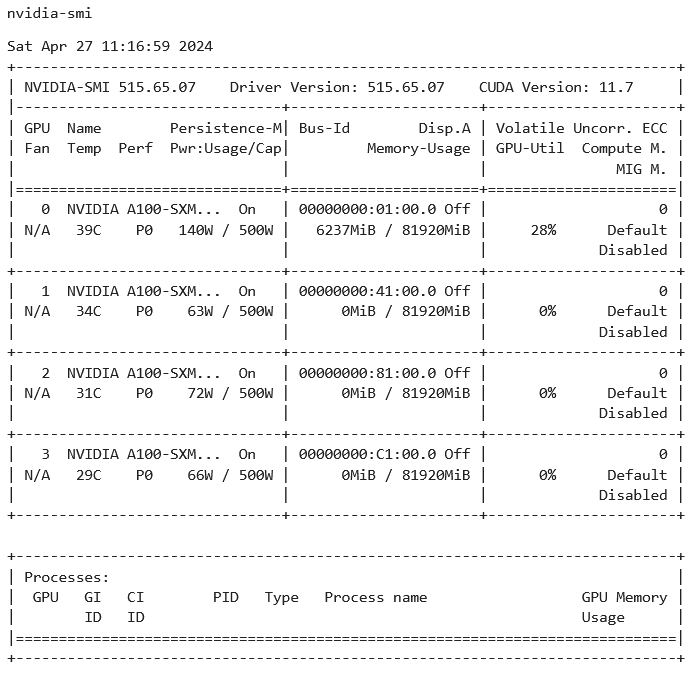

The *train* function from the GitHub file *main.py* was updated in order to save the accuracies after each epoch and thus be able to visualize the training process afterwards. The following codeblock trains the model.

In [18]:
start_time = time.time()

# execute command line call
root_folder = '../PlantNet-300K-dataset/images'
command = f'run main.py --lr=0.01 --batch_size=32 --mu=0.0001 --n_epochs=30 --epoch_decay 20 25 --k 1 3 5 10 --model=resnet18 --pretrained --seed=4 --image_size=256 --crop_size=224 --root={root_folder} --save_name_xp=resnet18_reproduction'
get_ipython().run_line_magic('time', command)

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Seed:	 4


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



USING GPU
args.k :  [1, 3, 5, 10]


val:   0%|          | 0/973 [00:00<?, ?it/s]/home/paulb001/PlantNet-300K/epoch.py:79: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

epoch:   3%|▎         | 1/30 [19:18<9:20:03, 1158.74s/it]


epoch 0 took 1158.74
loss_train : 2.0253650160879677
loss_val : 1.6414614379896548
acc_train : 0.5540696721311476 / topk_acc_train : {1: 0.5540696721311476, 3: 0.736766393442623, 5: 0.7966516393442623, 10: 0.8577418032786885}
acc_val : 0.625939970435118 / topk_acc_val : {1: 0.625939970435118, 3: 0.7989266662381901, 5: 0.8527540330355421, 10: 0.9035285044025966} / avgk_acc_val : {1: 0.6406581399832895, 3: 0.8261135034385243, 5: 0.8769522462883219, 10: 0.9215887910534096}


epoch:   7%|▋         | 2/30 [25:58<5:32:29, 712.49s/it] 


epoch 1 took 400.11
loss_train : 1.354223910672248
loss_val : 1.3566009196234339
acc_train : 0.6685245901639344 / topk_acc_train : {1: 0.6685245901639344, 3: 0.8410409836065573, 5: 0.8878729508196721, 10: 0.9307663934426229}
acc_val : 0.6822417893180796 / topk_acc_val : {1: 0.6822417893180796, 3: 0.8432097178481908, 5: 0.8889388778199113, 10: 0.9259271161385693} / avgk_acc_val : {1: 0.6923002763673758, 3: 0.8718105276688733, 5: 0.9113053538145125, 10: 0.9445979818754419}


epoch:  10%|█         | 3/30 [32:39<4:16:26, 569.88s/it]


epoch 2 took 400.16
loss_train : 1.1543911121128927
loss_val : 1.262448835903357
acc_train : 0.7057704918032787 / topk_acc_train : {1: 0.7057704918032787, 3: 0.8726680327868852, 5: 0.9138114754098361, 10: 0.9480614754098361}
acc_val : 0.6921074619191465 / topk_acc_val : {1: 0.6921074619191465, 3: 0.8584099235169356, 5: 0.9006684234205283, 10: 0.9369818111703837} / avgk_acc_val : {1: 0.7057651520020567, 3: 0.8858538466482422, 5: 0.9231955781219873, 10: 0.9549456905970821}


epoch:  13%|█▎        | 4/30 [39:15<3:37:15, 501.37s/it]


epoch 3 took 396.34
loss_train : 1.040098660628449
loss_val : 1.1899426602471022
acc_train : 0.7288688524590164 / topk_acc_train : {1: 0.7288688524590164, 3: 0.8888729508196721, 5: 0.9271516393442623, 10: 0.957516393442623}
acc_val : 0.711067549328363 / topk_acc_val : {1: 0.711067549328363, 3: 0.8704286907898965, 5: 0.9084774085738158, 10: 0.9414808149624012} / avgk_acc_val : {1: 0.721865158429205, 3: 0.8961372838871393, 5: 0.9300726267754997, 10: 0.9586413008548107}


epoch:  17%|█▋        | 5/30 [45:56<3:13:48, 465.12s/it]


epoch 4 took 400.86
loss_train : 0.9658429169888605
loss_val : 1.1690410713783999
acc_train : 0.7442704918032786 / topk_acc_train : {1: 0.7442704918032786, 3: 0.9014180327868853, 5: 0.9361147540983606, 10: 0.9633606557377049}
acc_val : 0.7106497846905329 / topk_acc_val : {1: 0.7106497846905329, 3: 0.8720033421171026, 5: 0.9129764123658333, 10: 0.9457227328234462} / avgk_acc_val : {1: 0.7217044797223472, 3: 0.9011825952824731, 5: 0.9344109518606595, 10: 0.9615335175782506}


epoch:  20%|██        | 6/30 [52:45<2:58:24, 446.01s/it]


epoch 5 took 408.90
loss_train : 0.9107865651273965
loss_val : 1.1532424898365887
acc_train : 0.7550655737704918 / topk_acc_train : {1: 0.7550655737704918, 3: 0.9095204918032787, 5: 0.9425040983606557, 10: 0.9679631147540984}
acc_val : 0.7163699466546694 / topk_acc_val : {1: 0.7163699466546694, 3: 0.8743171154958544, 5: 0.9150973712963558, 10: 0.9481650491676843} / avgk_acc_val : {1: 0.727906677807057, 3: 0.9023716177132206, 5: 0.9364355035670673, 10: 0.9636866122501446}


epoch:  23%|██▎       | 7/30 [59:25<2:45:14, 431.06s/it]


epoch 6 took 400.29
loss_train : 0.8696213194402668
loss_val : 1.1299887915513642
acc_train : 0.763594262295082 / topk_acc_train : {1: 0.763594262295082, 3: 0.9150696721311475, 5: 0.9465409836065574, 10: 0.9709508196721311}
acc_val : 0.721286715084517 / topk_acc_val : {1: 0.721286715084517, 3: 0.879748055787647, 5: 0.9175396876405939, 10: 0.9502538723568352} / avgk_acc_val : {1: 0.73086316601324, 3: 0.9073526576258114, 5: 0.93897422713542, 10: 0.9641686483707179}


epoch:  27%|██▋       | 8/30 [1:06:05<2:34:28, 421.31s/it]


epoch 7 took 400.44
loss_train : 0.8327072977038552
loss_val : 1.1407821625011203
acc_train : 0.770905737704918 / topk_acc_train : {1: 0.770905737704918, 3: 0.9208237704918033, 5: 0.9514590163934427, 10: 0.9740532786885245}
acc_val : 0.7207404074812006 / topk_acc_val : {1: 0.7207404074812006, 3: 0.8791374767015875, 5: 0.9189215245195707, 10: 0.9493862073398033} / avgk_acc_val : {1: 0.7313130663924416, 3: 0.9043640336782569, 5: 0.9364997750498104, 10: 0.9642971913362042}


epoch:  30%|███       | 9/30 [1:12:58<2:26:31, 418.66s/it]


epoch 8 took 412.82
loss_train : 0.8049132556704353
loss_val : 1.1090046144991255
acc_train : 0.7762950819672131 / topk_acc_train : {1: 0.7762950819672131, 3: 0.9245122950819672, 5: 0.9544754098360656, 10: 0.9760696721311476}
acc_val : 0.7246609679285301 / topk_acc_val : {1: 0.7246609679285301, 3: 0.8835079375281187, 5: 0.9220065556912398, 10: 0.9513143518220966} / avgk_acc_val : {1: 0.7353621698052574, 3: 0.9096664310045632, 5: 0.942862651841378, 10: 0.9672858152837586}


epoch:  33%|███▎      | 10/30 [1:19:54<2:19:18, 417.90s/it]


epoch 9 took 416.20
loss_train : 0.7784564053622179
loss_val : 1.1186132652094825
acc_train : 0.7820040983606558 / topk_acc_train : {1: 0.7820040983606558, 3: 0.9289918032786886, 5: 0.9574098360655737, 10: 0.9777213114754099}
acc_val : 0.7254000899800759 / topk_acc_val : {1: 0.7254000899800759, 3: 0.8835079375281187, 5: 0.9210746191914647, 10: 0.9526961887010733} / avgk_acc_val : {1: 0.7359727488913169, 3: 0.9085095443151874, 5: 0.9408059643935985, 10: 0.9659682498875249}


epoch:  37%|███▋      | 11/30 [1:26:37<2:10:53, 413.32s/it]


epoch 10 took 402.93
loss_train : 0.7603587432777175
loss_val : 1.1379843353305334
acc_train : 0.7856393442622951 / topk_acc_train : {1: 0.7856393442622951, 3: 0.9314262295081968, 5: 0.9599385245901639, 10: 0.9791762295081967}
acc_val : 0.7203869143261135 / topk_acc_val : {1: 0.7203869143261135, 3: 0.8783340831672987, 5: 0.918825117295456, 10: 0.9497397004948904} / avgk_acc_val : {1: 0.7304454013754097, 3: 0.9078025580050132, 5: 0.9396490777042227, 10: 0.9649077704222636}


epoch:  40%|████      | 12/30 [1:33:17<2:02:47, 409.28s/it]


epoch 11 took 400.04
loss_train : 0.7351718254012113
loss_val : 1.1382267301434597
acc_train : 0.7912704918032787 / topk_acc_train : {1: 0.7912704918032787, 3: 0.9348811475409836, 5: 0.9619098360655738, 10: 0.9808893442622951}
acc_val : 0.7232469953081817 / topk_acc_val : {1: 0.7232469953081817, 3: 0.879748055787647, 5: 0.9183430811748827, 10: 0.9504466868050646} / avgk_acc_val : {1: 0.7334661610643357, 3: 0.9052316986952889, 5: 0.9379780191529019, 10: 0.9661932000771257}


epoch:  43%|████▎     | 13/30 [1:39:57<1:55:10, 406.48s/it]


epoch 12 took 400.03
loss_train : 0.7183572762965343
loss_val : 1.1233627788661193
acc_train : 0.7954303278688525 / topk_acc_train : {1: 0.7954303278688525, 3: 0.9380040983606558, 5: 0.9642786885245902, 10: 0.9821229508196722}
acc_val : 0.7297384150652355 / topk_acc_val : {1: 0.7297384150652355, 3: 0.8840221093900636, 5: 0.9204961758467768, 10: 0.9517321164599267} / avgk_acc_val : {1: 0.7397004948904171, 3: 0.9101484671251365, 5: 0.9401632495661675, 10: 0.963943698181117}


epoch:  47%|████▋     | 14/30 [1:46:36<1:47:47, 404.23s/it]


epoch 13 took 399.05
loss_train : 0.7046919788125461
loss_val : 1.1478939114345446
acc_train : 0.7963770491803279 / topk_acc_train : {1: 0.7963770491803279, 3: 0.9398606557377049, 5: 0.9661516393442623, 10: 0.9831270491803279}
acc_val : 0.7183623626197057 / topk_acc_val : {1: 0.7183623626197057, 3: 0.8816762002699402, 5: 0.9200784112089466, 10: 0.9507359084774085} / avgk_acc_val : {1: 0.7290314287550613, 3: 0.9080596439359856, 5: 0.9395848062214796, 10: 0.9652291278359791}


epoch:  50%|█████     | 15/30 [1:53:15<1:40:37, 402.47s/it]


epoch 14 took 398.37
loss_train : 0.6889917501390121
loss_val : 1.1286146945852802
acc_train : 0.801655737704918 / topk_acc_train : {1: 0.801655737704918, 3: 0.9417909836065573, 5: 0.9675, 10: 0.9841926229508197}
acc_val : 0.7250465968249887 / topk_acc_val : {1: 0.7250465968249887, 3: 0.8819654219422842, 5: 0.9185680313644836, 10: 0.9506395012532939} / avgk_acc_val : {1: 0.7335304325470788, 3: 0.9078668294877563, 5: 0.9389420913940485, 10: 0.9644900057844334}


epoch:  53%|█████▎    | 16/30 [1:59:54<1:33:42, 401.63s/it]


epoch 15 took 399.67
loss_train : 0.6751991845540319
loss_val : 1.1149594899987487
acc_train : 0.8040983606557377 / topk_acc_train : {1: 0.8040983606557377, 3: 0.9440122950819673, 5: 0.9683811475409836, 10: 0.984688524590164}
acc_val : 0.7320200527026158 / topk_acc_val : {1: 0.7320200527026158, 3: 0.8876534481650492, 5: 0.9239668359149046, 10: 0.9536602609422199} / avgk_acc_val : {1: 0.7421428112346552, 3: 0.9120123401246867, 5: 0.9414486792210296, 10: 0.9662574715598689}


epoch:  57%|█████▋    | 17/30 [2:06:41<1:27:18, 402.99s/it]


epoch 16 took 406.16
loss_train : 0.6648530329783825
loss_val : 1.1155348021245788
acc_train : 0.8064467213114754 / topk_acc_train : {1: 0.8064467213114754, 3: 0.9457540983606557, 5: 0.9698893442622951, 10: 0.9855409836065574}
acc_val : 0.7277781348415708 / topk_acc_val : {1: 0.7277781348415708, 3: 0.8852754033035543, 5: 0.9221672343980976, 10: 0.951860659425413} / avgk_acc_val : {1: 0.7376759431840093, 3: 0.9099877884182788, 5: 0.9418021723761167, 10: 0.9658397069220387}


epoch:  60%|██████    | 18/30 [2:13:21<1:20:24, 402.08s/it]


epoch 17 took 399.96
loss_train : 0.6497879640813936
loss_val : 1.1066152990906817
acc_train : 0.8101721311475409 / topk_acc_train : {1: 0.8101721311475409, 3: 0.9473647540983606, 5: 0.9711598360655738, 10: 0.9865614754098361}
acc_val : 0.7303168584099236 / topk_acc_val : {1: 0.7303168584099236, 3: 0.8877177196477922, 5: 0.9253165370525098, 10: 0.9543351115110226} / avgk_acc_val : {1: 0.7398611735972749, 3: 0.9134584484864066, 5: 0.9440838100134971, 10: 0.9671572723182724}


epoch:  63%|██████▎   | 19/30 [2:20:01<1:13:36, 401.47s/it]


epoch 18 took 400.06
loss_train : 0.6407482446428361
loss_val : 1.1115798613079537
acc_train : 0.8125819672131147 / topk_acc_train : {1: 0.8125819672131147, 3: 0.9489508196721311, 5: 0.9722090163934426, 10: 0.987061475409836}
acc_val : 0.7320200527026158 / topk_acc_val : {1: 0.7320200527026158, 3: 0.8873642264927052, 5: 0.9247059579664503, 10: 0.9537566681663346} / avgk_acc_val : {1: 0.7398290378559034, 3: 0.9105340960215952, 5: 0.9413844077382866, 10: 0.9658397069220387}


epoch:  67%|██████▋   | 20/30 [2:26:45<1:07:04, 402.41s/it]


epoch 19 took 404.58
loss_train : 0.6331550921660389
loss_val : 1.1219318710696795
acc_train : 0.8142868852459016 / topk_acc_train : {1: 0.8142868852459016, 3: 0.9498647540983607, 5: 0.9728934426229509, 10: 0.9873852459016393}
acc_val : 0.7304454013754097 / topk_acc_val : {1: 0.7304454013754097, 3: 0.8859502538723568, 5: 0.9232277138633588, 10: 0.9533067677871329} / avgk_acc_val : {1: 0.7399575808213895, 3: 0.911915932900572, 5: 0.9418985796002314, 10: 0.9658718426634102}
Switching lr to 0.001


epoch:  70%|███████   | 21/30 [2:33:53<1:01:29, 409.97s/it]


epoch 20 took 427.59
loss_train : 0.37602752283926966
loss_val : 0.9006019489985312
acc_train : 0.8876065573770492 / topk_acc_train : {1: 0.8876065573770492, 3: 0.9783196721311476, 5: 0.989405737704918, 10: 0.9952090163934426}
acc_val : 0.7797094928980012 / topk_acc_val : {1: 0.7797094928980012, 3: 0.9156758146410438, 5: 0.9442444887203548, 10: 0.9655504852496947} / avgk_acc_val : {1: 0.7870043061893438, 3: 0.9396169419628511, 5: 0.9606979883025901, 10: 0.978051288643229}


epoch:  73%|███████▎  | 22/30 [2:40:57<55:14, 414.29s/it]  


epoch 21 took 424.38
loss_train : 0.3129639602559428
loss_val : 0.8998635196330126
acc_train : 0.9057008196721311 / topk_acc_train : {1: 0.9057008196721311, 3: 0.9849508196721312, 5: 0.992655737704918, 10: 0.9967254098360656}
acc_val : 0.7809306510701202 / topk_acc_val : {1: 0.7809306510701202, 3: 0.9157400861237869, 5: 0.9442123529789832, 10: 0.9661289285943827} / avgk_acc_val : {1: 0.7878398354650041, 3: 0.9396490777042227, 5: 0.9608265312680764, 10: 0.9784047817983161}


epoch:  77%|███████▋  | 23/30 [2:47:43<48:01, 411.63s/it]


epoch 22 took 405.41
loss_train : 0.2854405396985885
loss_val : 0.9040064164073256
acc_train : 0.9149713114754099 / topk_acc_train : {1: 0.9149713114754099, 3: 0.987061475409836, 5: 0.9939795081967213, 10: 0.9973647540983607}
acc_val : 0.7799344430876021 / topk_acc_val : {1: 0.7799344430876021, 3: 0.9153544572273282, 5: 0.944662253358185, 10: 0.9657754354392956} / avgk_acc_val : {1: 0.7865865415515136, 3: 0.9388456841699337, 5: 0.9609872099749341, 10: 0.9780834243846006}


epoch:  80%|████████  | 24/30 [2:54:41<41:21, 413.52s/it]


epoch 23 took 417.92
loss_train : 0.26570972409475585
loss_val : 0.9131523995303813
acc_train : 0.921094262295082 / topk_acc_train : {1: 0.921094262295082, 3: 0.9888401639344262, 5: 0.994938524590164, 10: 0.9977622950819672}
acc_val : 0.7777813484157079 / topk_acc_val : {1: 0.7777813484157079, 3: 0.9140368918310945, 5: 0.9438909955652677, 10: 0.9668037791631853} / avgk_acc_val : {1: 0.7851725689311653, 3: 0.9387171412044476, 5: 0.9597339160614435, 10: 0.9770229449193393}


epoch:  83%|████████▎ | 25/30 [3:01:22<34:09, 409.94s/it]


epoch 24 took 401.61
loss_train : 0.2488790879217597
loss_val : 0.9164583332867289
acc_train : 0.9266885245901639 / topk_acc_train : {1: 0.9266885245901639, 3: 0.9902049180327869, 5: 0.9953975409836066, 10: 0.9979344262295082}
acc_val : 0.7795488141911434 / topk_acc_val : {1: 0.7795488141911434, 3: 0.916157850761617, 5: 0.9451764252201298, 10: 0.9666752361976991} / avgk_acc_val : {1: 0.787422070827174, 3: 0.938106562118388, 5: 0.9594768301304711, 10: 0.9769265376952246}
Switching lr to 0.0001


epoch:  87%|████████▋ | 26/30 [3:08:20<27:28, 412.20s/it]


epoch 25 took 417.46
loss_train : 0.22511816873476065
loss_val : 0.9092702271930352
acc_train : 0.9352745901639344 / topk_acc_train : {1: 0.9352745901639344, 3: 0.991938524590164, 5: 0.9963688524590164, 10: 0.9984385245901639}
acc_val : 0.7806414293977763 / topk_acc_val : {1: 0.7806414293977763, 3: 0.9162863937271033, 5: 0.9451121537373868, 10: 0.9665466932322129} / avgk_acc_val : {1: 0.7881933286200913, 3: 0.9389099556526769, 5: 0.9601838164406453, 10: 0.9767979947297384}


epoch:  90%|█████████ | 27/30 [3:15:03<20:28, 409.42s/it]


epoch 26 took 402.94
loss_train : 0.22220881614792048
loss_val : 0.9134102056546466
acc_train : 0.9359508196721311 / topk_acc_train : {1: 0.9359508196721311, 3: 0.9919549180327869, 5: 0.9963975409836066, 10: 0.9984549180327869}
acc_val : 0.780866379587377 / topk_acc_val : {1: 0.780866379587377, 3: 0.9172183302268784, 5: 0.9451442894787583, 10: 0.9669323221286715} / avgk_acc_val : {1: 0.7881611928787197, 3: 0.9393919917732502, 5: 0.9600874092165306, 10: 0.9765730445401375}


epoch:  93%|█████████▎| 28/30 [3:21:45<13:34, 407.25s/it]


epoch 27 took 402.18
loss_train : 0.21941626156950986
loss_val : 0.9157065647067847
acc_train : 0.9368811475409836 / topk_acc_train : {1: 0.9368811475409836, 3: 0.9923196721311476, 5: 0.9964016393442623, 10: 0.9984467213114754}
acc_val : 0.781380551449322 / topk_acc_val : {1: 0.781380551449322, 3: 0.9157722218651584, 5: 0.9448872035477859, 10: 0.9666431004563275} / avgk_acc_val : {1: 0.7886753647406646, 3: 0.9384600552734752, 5: 0.9593482871649849, 10: 0.9771193521434539}


epoch:  97%|█████████▋| 29/30 [3:28:35<06:48, 408.10s/it]


epoch 28 took 410.08
loss_train : 0.21730134044827626
loss_val : 0.9089568559494283
acc_train : 0.9383442622950819 / topk_acc_train : {1: 0.9383442622950819, 3: 0.9923360655737705, 5: 0.9965737704918033, 10: 0.9985860655737705}
acc_val : 0.781669773121666 / topk_acc_val : {1: 0.781669773121666, 3: 0.9163506652098464, 5: 0.9451764252201298, 10: 0.9666431004563275} / avgk_acc_val : {1: 0.7887717719647792, 3: 0.9386528697217045, 5: 0.9604730381129892, 10: 0.9770872164020824}


epoch: 100%|██████████| 30/30 [3:35:12<00:00, 430.41s/it]



epoch 29 took 396.97
loss_train : 0.215712111135202
loss_val : 0.913362242917649
acc_train : 0.9389959016393442 / topk_acc_train : {1: 0.9389959016393442, 3: 0.9923073770491804, 5: 0.9966229508196721, 10: 0.9985409836065574}
acc_val : 0.7815412301561797 / topk_acc_val : {1: 0.7815412301561797, 3: 0.9163506652098464, 5: 0.9447586605822996, 10: 0.9673179510251302} / avgk_acc_val : {1: 0.7881933286200913, 3: 0.9384279195321036, 5: 0.9596696445787004, 10: 0.9767337232469953}



test:   0%|          | 0/973 [00:00<?, ?it/s]/home/paulb001/PlantNet-300K/epoch.py:154: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

test: 100%|██████████| 973/973 [00:45<00:00, 21.46it/s]


CPU times: user 1h 25min 28s, sys: 23min 48s, total: 1h 49min 16s
Wall time: 3h 36min 3s
total time taken: 3h 36m 3.96s


In order to be able to compare training progress between different training cycles, the training data is renamed in the next code block.

In [19]:
# rename the file
current_file_path = './results/epoch_acc_train_val.csv'
new_file_path = './results/epoch_acc_train_val_standard.csv'
os.rename(current_file_path, new_file_path)

The code block below visualizes the training progress. The lines highlight the learning rate decay at epoch 20. The decay at epoch 25 did not had a significant impact on the accuracy. Learning rate decay means that at epoch 20 and 25 the learning rate is decreased. This helps the model to finetune the weights more precisely once the model already optimized the weights with larger learning rates. In this specific implementation the learning rate decays to 10 percent of the original value, as can be seen in the *decay_lr* function in the *utils.py* script. 

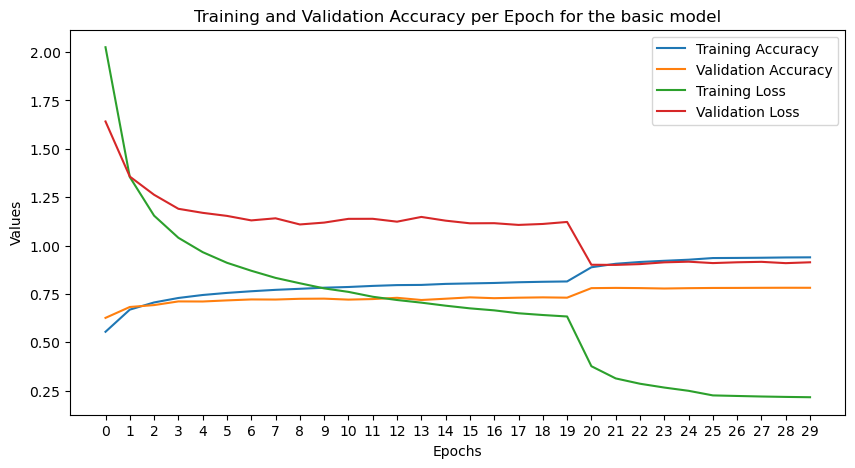

In [17]:
# read training progress data
df_epoch_acc = pd.read_csv('./results/epoch_acc_train_val_standard.csv')

# visualize training progress data
plt.figure(figsize=(10, 5))

# plot the data
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_train'], label='Training Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_val'], label='Validation Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_train'], label='Training Loss')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_val'], label='Validation Loss')

# add titles and labels
plt.title('Training and Validation Accuracy per Epoch for the basic model')
plt.xlabel('Epochs')
plt.ylabel('Values')

# display the legend
plt.legend()

# set x-axis ticks to show integers only
plt.xticks(range(df_epoch_acc['epoch'].min(), df_epoch_acc['epoch'].max()+1))

# save the figure as a PNG file
plt.savefig('./results/training_standard.png', format='png', dpi=300)

# save the figure as a SVG vector graphic
plt.savefig('./results/training_standard.svg', format='svg')

plt.show()

The next code block calculates the final accuracy on the test set.

In [5]:
start_time = time.time()

filename = './results/resnet18_reproduction/resnet18_reproduction_weights_best_acc.tar'
model_name = 'resnet18'
        
# load the model
model = pytorch_models[model_name](num_classes=1081)

# Load model weights and set to evaluation mode
load_model(model, filename=filename, use_gpu=use_gpu)
model.eval()
if use_gpu and torch.cuda.is_available():
    model.cuda()

# collect softmax outputs
softmax_outputs = []
labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        if use_gpu and torch.cuda.is_available():
            inputs = inputs.cuda()

        outputs = model(inputs)
        softmax_outputs.append(outputs.cpu().numpy())
        labels.append(targets.cpu().numpy())

softmax_outputs = np.concatenate(softmax_outputs, axis=0)
labels = np.concatenate(labels, axis=0)

# convert averaged softmax outputs to predicted classes
_, predictions = torch.max(torch.tensor(softmax_outputs), 1)

# calculate accuracy
correct = (predictions.numpy() == labels).sum()
total = labels.size
average_accuracy = correct / total

# calculate per-class accuracy
cm = confusion_matrix(labels, predictions.numpy())
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# count classes with over 90% accuracy
count_over_90 = np.sum(per_class_accuracy > 0.9)
count_under_90 = len(per_class_accuracy) - count_over_90

# print results
print(f'Accuracy for the continued training model: {average_accuracy}')
print(f'Number of classes with accuracy over 90%: {count_over_90}')
print(f'Number of classes with accuracy under 90%: {count_under_90}')

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Accuracy for the continued training model: 0.7790417429865998
Number of classes with accuracy over 90%: 88
Number of classes with accuracy under 90%: 993
total time taken: 0h 0m 52.01s


As can be seen the model has about the same accuracy as the provided ResNet-18 model. The code was initialized correctly and the models are verified.

# Four possible approaches for improving model accuracy <a id="optimization_approaches"></a>

This chapter shows four different approaches for improving the model accuracy. The approaches are:
1. Data Augmentation
2. Oversampling and Undersampling of input data
3. Changing the loss function (weighted loss function based on data distribution)
4. Continued training of a checkpoint model in conjunction with the above approaches. 

Besides *main.py*, the files *cli.py* and *utils.py* in the repository also had to be adapted to implement these changes. 

## Data Augmentation <a id="augmentation"></a>
Since it was discovered in the EDA that the dataset is heavily skewed, this chapter tests whether a data augmentation approach improves the accuracy. Data augmentation describes the enhancement of training data by augmenting (changing) the data, for example by changing the orientation, color or sharpness.

The original images are shown below.

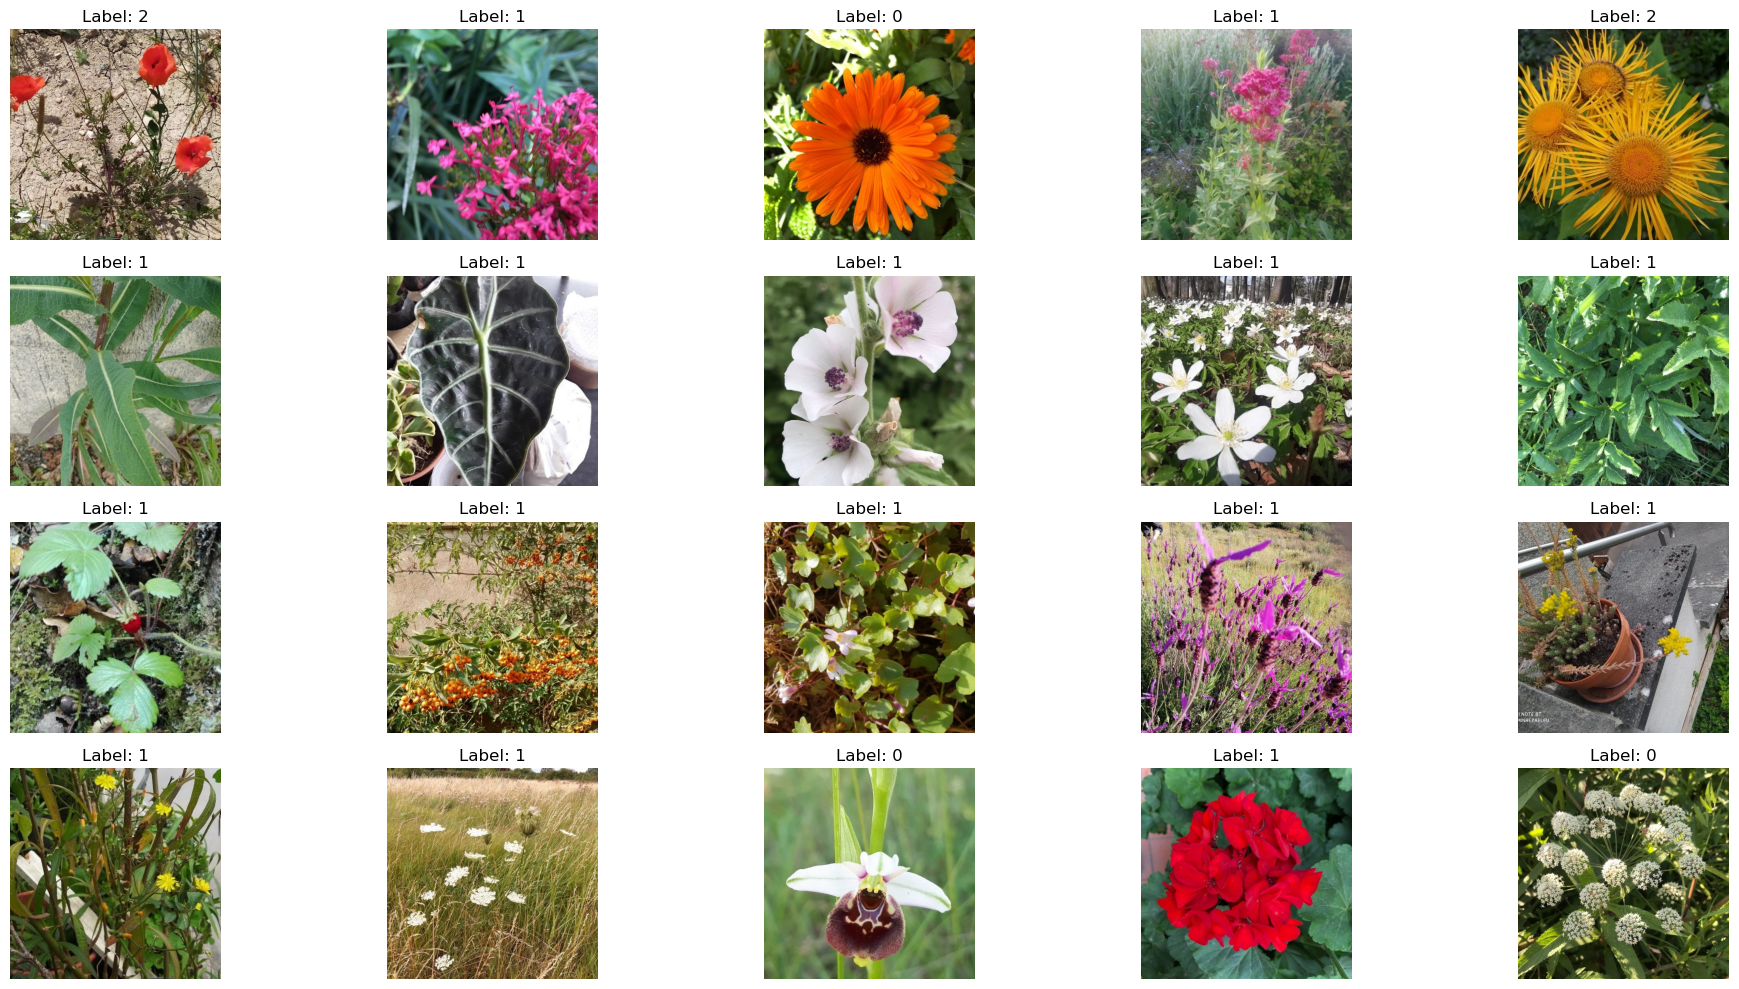

In [26]:
root_folder = '../PlantNet-300K-dataset/images'
dataset = ImageFolder(root=root_folder)

# define output format
num_images = 20
num_rows = 4
num_columns = 5
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))
axes = axes.ravel()

# output random images
for i in range(num_images):
    index = random.randint(0, len(dataset) - 1)
    image, label = dataset[index]
    image = transforms.ToTensor()(image)
    image = transforms.ToPILImage()(image)  # convert tensor image to PIL image for display
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()  # adjusts spacing between images

# save the figure as a PNG file
plt.savefig('./results/image_grid.png', format='png', dpi=300)

# save the figure as a SVG vector graphic
plt.savefig('./results/image_grid.svg', format='svg')

plt.show()

In [27]:
additional_transforms = transforms.Compose([
    # transforms.RandomGrayscale(p=0.1),
    # transforms.RandomInvert(p=0.1),
    # transforms.RandomPosterize(bits=2, p=0.1),
    # transforms.RandomSolarize(threshold=128, p=0.1),
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
    # transforms.RandomAutocontrast(p=0.1),
    # transforms.RandomEqualize(p=0.1),
    # transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.5, hue=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.ToTensor(),
])

For comparison the images with additional augmentation are shown below.

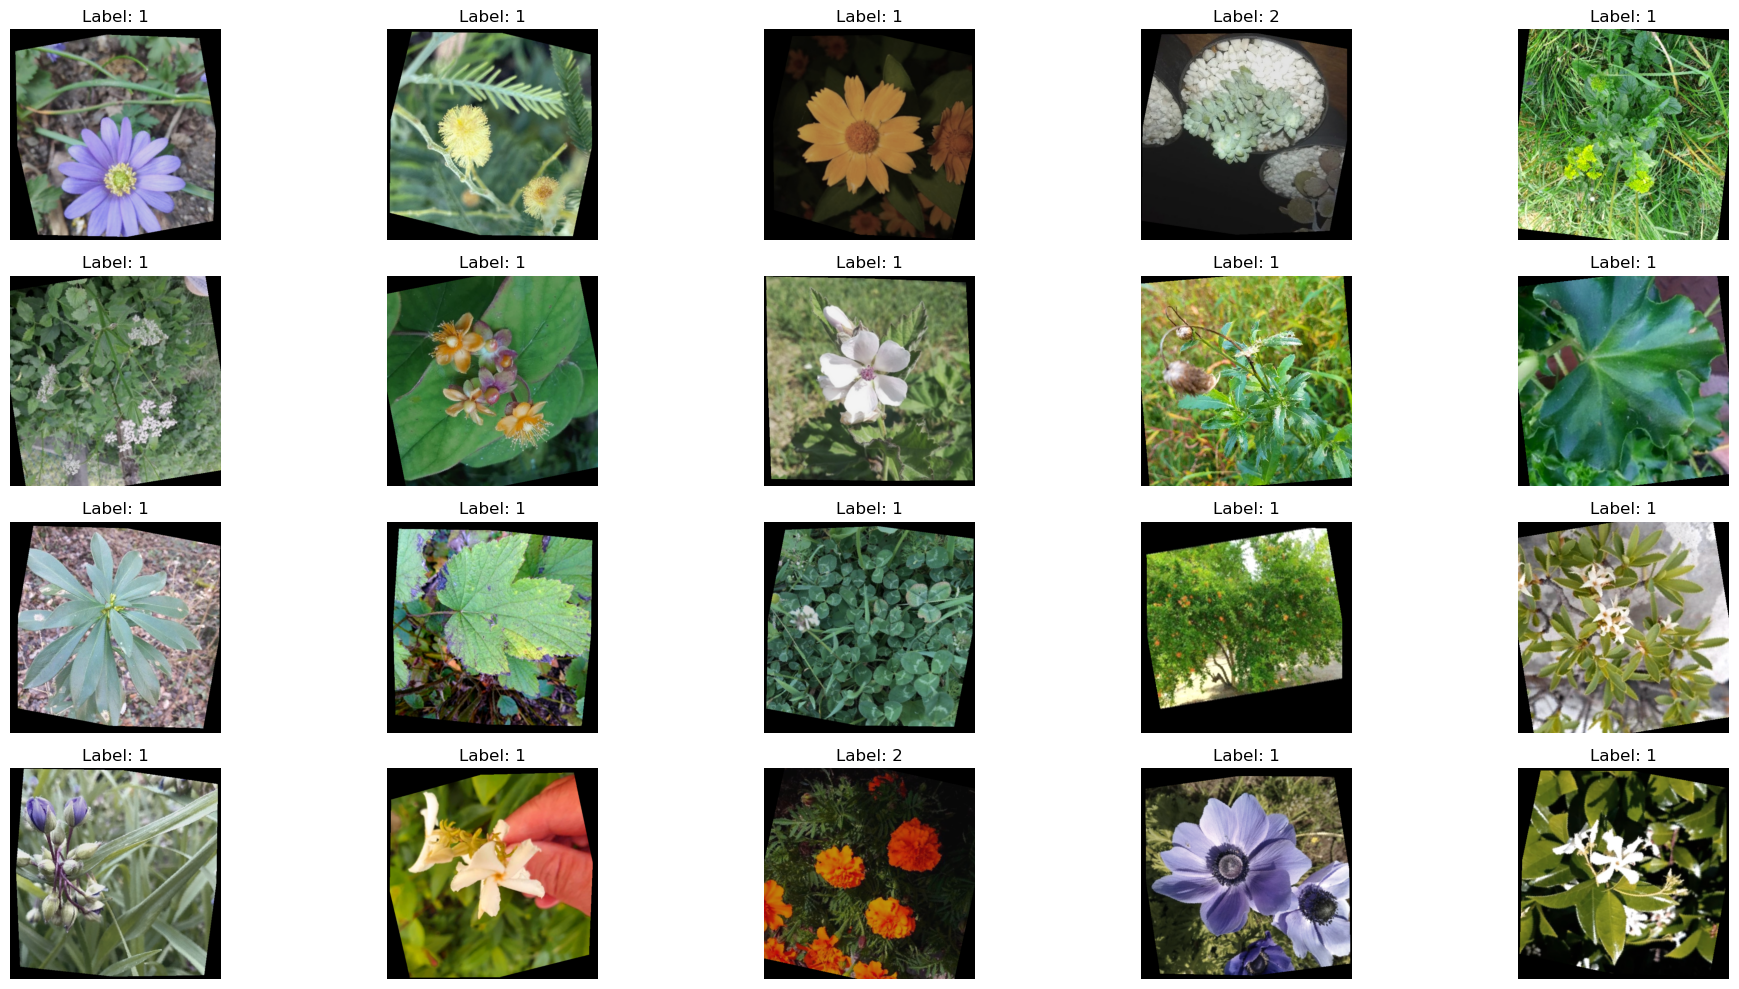

In [28]:
# define output format
num_images = 20
num_rows = 4
num_columns = 5
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))
axes = axes.ravel()

# output random images
for i in range(num_images):
    index = random.randint(0, len(dataset) - 1)
    image, label = dataset[index]
    image = additional_transforms(image) # perform additional transformations
    image = transforms.ToPILImage()(image)  # convert tensor image to PIL image for display
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()  # adjust spacing between images

# save the figure as a PNG file
plt.savefig('./results/image_grid_augmented.png', format='png', dpi=300)

# save the figure as a SVG vector graphic
plt.savefig('./results/image_grid_augmented.svg', format='svg')

plt.show()

The changes might seem small, but models tend to be quite sensitive to small changes. More aggressive augmentations were tested and lead to noticeably worse performing models. 

In the following code block, a model is trained with additional augmentation. The augmentation only takes place for classes that have fewer than 1,000 images. This approach can be controlled by the additional parameter *threshold=1000*. For this implementation the exact augmentation shown above is used and hard-coded in the *Plantnet class* in the *utils.py* script.

In [36]:
start_time = time.time()

# execute command line call
root_folder = '../PlantNet-300K-dataset/images'
command = f'run main.py --lr=0.01 --batch_size=32 --mu=0.0001 --n_epochs=30 --epoch_decay 20 25 --k 1 3 5 10 --model=resnet18 --pretrained --seed=4 --image_size=256 --crop_size=224 --threshold=1000 --root={root_folder} --save_name_xp=resnet18_augmentation'
get_ipython().run_line_magic('time', command)

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Seed:	 4


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



USING GPU
args.k :  [1, 3, 5, 10]


val:   0%|          | 0/973 [00:00<?, ?it/s]/home/paulb001/PlantNet-300K/epoch.py:79: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

epoch:   3%|▎         | 1/30 [07:07<3:26:29, 427.23s/it]


epoch 0 took 427.23
loss_train : 2.024831400611531
loss_val : 1.6076057613999755
acc_train : 0.5550655737704918 / topk_acc_train : {1: 0.5550655737704918, 3: 0.7357786885245902, 5: 0.7962090163934427, 10: 0.8581352459016394}
acc_val : 0.6305353814512501 / topk_acc_val : {1: 0.6305353814512501, 3: 0.8070248730638215, 5: 0.858956231120252, 10: 0.9057137348158621} / avgk_acc_val : {1: 0.6459284015682242, 3: 0.8325085159714635, 5: 0.8818047432354265, 10: 0.9234526640529597}


epoch:   7%|▋         | 2/30 [14:07<3:17:20, 422.89s/it]


epoch 1 took 419.84
loss_train : 1.3554805046512286
loss_val : 1.3576089236961961
acc_train : 0.6669959016393443 / topk_acc_train : {1: 0.6669959016393443, 3: 0.8413401639344262, 5: 0.8890368852459016, 10: 0.9304508196721312}
acc_val : 0.6831094543351115 / topk_acc_val : {1: 0.6831094543351115, 3: 0.8444630117616814, 5: 0.8898065428369433, 10: 0.9282087537759496} / avgk_acc_val : {1: 0.6941320136255543, 3: 0.8706536409794974, 5: 0.9113053538145125, 10: 0.9442123529789832}


epoch:  10%|█         | 3/30 [20:55<3:07:15, 416.12s/it]


epoch 2 took 408.06
loss_train : 1.1549783868545125
loss_val : 1.2788356520511486
acc_train : 0.7070573770491804 / topk_acc_train : {1: 0.7070573770491804, 3: 0.87275, 5: 0.9131270491803278, 10: 0.9477868852459016}
acc_val : 0.6915290185744585 / topk_acc_val : {1: 0.6915290185744585, 3: 0.8557426569830966, 5: 0.898386785783148, 10: 0.9346037663088888} / avgk_acc_val : {1: 0.7045761295713092, 3: 0.8844398740278938, 5: 0.9202390899158044, 10: 0.9528247316665596}


epoch:  13%|█▎        | 4/30 [27:40<2:58:23, 411.68s/it]


epoch 3 took 404.88
loss_train : 1.0419755651452358
loss_val : 1.172585449560925
acc_train : 0.7294467213114754 / topk_acc_train : {1: 0.7294467213114754, 3: 0.8889672131147541, 5: 0.927, 10: 0.9571926229508196}
acc_val : 0.7151166527411787 / topk_acc_val : {1: 0.7151166527411787, 3: 0.8717141204447587, 5: 0.912205154572916, 10: 0.9432482807378366} / avgk_acc_val : {1: 0.7257535831351629, 3: 0.9003470660068128, 5: 0.9323221286715084, 10: 0.9595732373545858}


epoch:  17%|█▋        | 5/30 [34:24<2:50:23, 408.93s/it]


epoch 4 took 404.06
loss_train : 0.965291623424852
loss_val : 1.2100799329916145
acc_train : 0.7440368852459016 / topk_acc_train : {1: 0.7440368852459016, 3: 0.9013319672131147, 5: 0.9360286885245902, 10: 0.9633975409836065}
acc_val : 0.7034835143646764 / topk_acc_val : {1: 0.7034835143646764, 3: 0.8663474516357093, 5: 0.9090879876598753, 10: 0.9427983803586348} / avgk_acc_val : {1: 0.7149238382929494, 3: 0.8957516549906807, 5: 0.9295263191721833, 10: 0.9585127578893246}


epoch:  20%|██        | 6/30 [41:14<2:43:47, 409.48s/it]


epoch 5 took 410.55
loss_train : 0.911613084420812
loss_val : 1.15992195870528
acc_train : 0.754405737704918 / topk_acc_train : {1: 0.754405737704918, 3: 0.9084877049180328, 5: 0.9421393442622951, 10: 0.9678483606557376}
acc_val : 0.7160164534995822 / topk_acc_val : {1: 0.7160164534995822, 3: 0.8738993508580243, 5: 0.9150009640722412, 10: 0.9461083617199049} / avgk_acc_val : {1: 0.7252394112732181, 3: 0.9003470660068128, 5: 0.9349251237226043, 10: 0.9624975898193971}


epoch:  23%|██▎       | 7/30 [48:15<2:38:23, 413.20s/it]


epoch 6 took 420.84
loss_train : 0.8690096780223868
loss_val : 1.134054599843398
acc_train : 0.763827868852459 / topk_acc_train : {1: 0.763827868852459, 3: 0.9148606557377049, 5: 0.9473196721311475, 10: 0.9710040983606557}
acc_val : 0.7186515842920497 / topk_acc_val : {1: 0.7186515842920497, 3: 0.8813227071148532, 5: 0.919403560640144, 10: 0.9505109582878077} / avgk_acc_val : {1: 0.7325342245645607, 3: 0.9074169291085545, 5: 0.9385564624975898, 10: 0.9643614628189472}


epoch:  27%|██▋       | 8/30 [55:11<2:31:49, 414.08s/it]


epoch 7 took 415.98
loss_train : 0.8327391401973063
loss_val : 1.162950825942642
acc_train : 0.7712131147540984 / topk_acc_train : {1: 0.7712131147540984, 3: 0.9206762295081967, 5: 0.9518237704918033, 10: 0.9739303278688525}
acc_val : 0.7174946976026737 / topk_acc_val : {1: 0.7174946976026737, 3: 0.8746706086509416, 5: 0.9143261135034385, 10: 0.9459155472716756} / avgk_acc_val : {1: 0.727328234462369, 3: 0.9012790025065879, 5: 0.9335111511022559, 10: 0.963011761681342}


epoch:  30%|███       | 9/30 [1:01:52<2:23:33, 410.16s/it]


epoch 8 took 401.52
loss_train : 0.805744878165932
loss_val : 1.1143336907151795
acc_train : 0.7763565573770492 / topk_acc_train : {1: 0.7763565573770492, 3: 0.9243524590163934, 5: 0.9543360655737705, 10: 0.9758852459016394}
acc_val : 0.724307474773443 / topk_acc_val : {1: 0.724307474773443, 3: 0.8841506523555498, 5: 0.9210746191914647, 10: 0.9516035734944405} / avgk_acc_val : {1: 0.7353621698052574, 3: 0.909762838228678, 5: 0.9411915932900572, 10: 0.9657754354392956}


epoch:  33%|███▎      | 10/30 [1:09:01<2:18:38, 415.91s/it]


epoch 9 took 428.80
loss_train : 0.7807568405097173
loss_val : 1.1218323316655041
acc_train : 0.7814262295081967 / topk_acc_train : {1: 0.7814262295081967, 3: 0.9285327868852459, 5: 0.9574508196721312, 10: 0.9778647540983607}
acc_val : 0.7237290314287551 / topk_acc_val : {1: 0.7237290314287551, 3: 0.883636480493605, 5: 0.9204319043640337, 10: 0.9510251301497525} / avgk_acc_val : {1: 0.7337875184780512, 3: 0.908605951539302, 5: 0.9401953853075391, 10: 0.9650363133877499}


epoch:  37%|███▋      | 11/30 [1:16:01<2:12:05, 417.13s/it]


epoch 10 took 419.87
loss_train : 0.7577347025345592
loss_val : 1.1383431127655164
acc_train : 0.7857581967213115 / topk_acc_train : {1: 0.7857581967213115, 3: 0.9320409836065574, 5: 0.9600327868852458, 10: 0.9795286885245902}
acc_val : 0.7209010861880584 / topk_acc_val : {1: 0.7209010861880584, 3: 0.8794266983739315, 5: 0.9179895880197956, 10: 0.9506073655119224} / avgk_acc_val : {1: 0.7314094736165563, 3: 0.907384793367183, 5: 0.9393919917732502, 10: 0.9659039784047818}


epoch:  40%|████      | 12/30 [1:23:04<2:05:38, 418.79s/it]


epoch 11 took 422.59
loss_train : 0.7352157611759518
loss_val : 1.13340099235621
acc_train : 0.7918934426229508 / topk_acc_train : {1: 0.7918934426229508, 3: 0.9354508196721312, 5: 0.9620081967213114, 10: 0.9807622950819672}
acc_val : 0.7216723439809757 / topk_acc_val : {1: 0.7216723439809757, 3: 0.8779163185294685, 5: 0.9185037598817405, 10: 0.9500289221672344} / avgk_acc_val : {1: 0.7325342245645607, 3: 0.9057780062986053, 5: 0.9388456841699337, 10: 0.965743299697924}


epoch:  43%|████▎     | 13/30 [1:29:44<1:57:01, 413.03s/it]


epoch 12 took 399.79
loss_train : 0.7184333533150264
loss_val : 1.091585214276618
acc_train : 0.7950901639344262 / topk_acc_train : {1: 0.7950901639344262, 3: 0.9374672131147541, 5: 0.963688524590164, 10: 0.9819631147540984}
acc_val : 0.737772350408124 / topk_acc_val : {1: 0.737772350408124, 3: 0.8894530496818561, 5: 0.9247702294491934, 10: 0.9532746320457613} / avgk_acc_val : {1: 0.7458705572337554, 3: 0.913715534417379, 5: 0.9424770229449193, 10: 0.966032521370268}


epoch:  47%|████▋     | 14/30 [1:36:29<1:49:30, 410.64s/it]


epoch 13 took 405.09
loss_train : 0.70594400801605
loss_val : 1.1138330058121877
acc_train : 0.7965655737704918 / topk_acc_train : {1: 0.7965655737704918, 3: 0.9400327868852459, 5: 0.9657581967213115, 10: 0.9830286885245901}
acc_val : 0.7251108683077319 / topk_acc_val : {1: 0.7251108683077319, 3: 0.8833793945626326, 5: 0.9236133427598174, 10: 0.954302975769651} / avgk_acc_val : {1: 0.7351372196156565, 3: 0.9117231184523427, 5: 0.9433125522205797, 10: 0.967478629731988}


epoch:  50%|█████     | 15/30 [1:43:25<1:43:07, 412.51s/it]


epoch 14 took 416.86
loss_train : 0.6873996936679981
loss_val : 1.0990246978929503
acc_train : 0.8017909836065574 / topk_acc_train : {1: 0.8017909836065574, 3: 0.9426639344262295, 5: 0.9678237704918032, 10: 0.9840655737704918}
acc_val : 0.7322450028922167 / topk_acc_val : {1: 0.7322450028922167, 3: 0.8862394755447008, 5: 0.9230348994151295, 10: 0.9532746320457613} / avgk_acc_val : {1: 0.7428819332862009, 3: 0.9110482678835401, 5: 0.9415772221865158, 10: 0.9675107654733595}


epoch:  53%|█████▎    | 16/30 [1:50:05<1:35:19, 408.51s/it]


epoch 15 took 399.21
loss_train : 0.6750577954401469
loss_val : 1.132317212567408
acc_train : 0.803561475409836 / topk_acc_train : {1: 0.803561475409836, 3: 0.9437868852459016, 5: 0.9686803278688525, 10: 0.9849754098360656}
acc_val : 0.7248216466353878 / topk_acc_val : {1: 0.7248216466353878, 3: 0.8853396747862973, 5: 0.9211388906742078, 10: 0.9511215373738672} / avgk_acc_val : {1: 0.7359406131499454, 3: 0.9090237161771322, 5: 0.9398740278938235, 10: 0.9650363133877499}


epoch:  57%|█████▋    | 17/30 [1:56:55<1:28:37, 409.02s/it]


epoch 16 took 410.21
loss_train : 0.6634947519469908
loss_val : 1.1000620994885517
acc_train : 0.8072049180327869 / topk_acc_train : {1: 0.8072049180327869, 3: 0.9453114754098361, 5: 0.9698155737704918, 10: 0.985577868852459}
acc_val : 0.7304454013754097 / topk_acc_val : {1: 0.7304454013754097, 3: 0.886368018510187, 5: 0.923645478501189, 10: 0.954013754097307} / avgk_acc_val : {1: 0.7415965036313388, 3: 0.9134905842277782, 5: 0.9434732309274375, 10: 0.9673822225078732}


epoch:  60%|██████    | 18/30 [2:03:53<1:22:19, 411.65s/it]


epoch 17 took 417.77
loss_train : 0.6498319385895761
loss_val : 1.1216031710613412
acc_train : 0.8107172131147541 / topk_acc_train : {1: 0.8107172131147541, 3: 0.947327868852459, 5: 0.9707622950819672, 10: 0.9866434426229508}
acc_val : 0.7274246416864837 / topk_acc_val : {1: 0.7274246416864837, 3: 0.8846969599588662, 5: 0.92242432032907, 10: 0.9520856096150139} / avgk_acc_val : {1: 0.7359084774085738, 3: 0.9104698245388521, 5: 0.9428305161000065, 10: 0.9666431004563275}


epoch:  63%|██████▎   | 19/30 [2:10:53<1:15:57, 414.29s/it]


epoch 18 took 420.43
loss_train : 0.6393235292508495
loss_val : 1.1003316457962058
acc_train : 0.8124836065573771 / topk_acc_train : {1: 0.8124836065573771, 3: 0.9487172131147541, 5: 0.972172131147541, 10: 0.9869303278688525}
acc_val : 0.7342695545986246 / topk_acc_val : {1: 0.7342695545986246, 3: 0.8866251044411595, 5: 0.9231955781219873, 10: 0.952503374252844} / avgk_acc_val : {1: 0.743235426441288, 3: 0.9106305032457099, 5: 0.942862651841378, 10: 0.9673179510251302}


epoch:  67%|██████▋   | 20/30 [2:17:55<1:09:27, 416.70s/it]


epoch 19 took 422.33
loss_train : 0.6331450121823194
loss_val : 1.1128133474676698
acc_train : 0.8133975409836065 / topk_acc_train : {1: 0.8133975409836065, 3: 0.9499918032786885, 5: 0.9729631147540984, 10: 0.987172131147541}
acc_val : 0.7313773378751848 / topk_acc_val : {1: 0.7313773378751848, 3: 0.8852111318208111, 5: 0.9214602480879234, 10: 0.9526640529597018} / avgk_acc_val : {1: 0.7415965036313388, 3: 0.9108875891766823, 5: 0.9410630503245709, 10: 0.9655504852496947}
Switching lr to 0.001


epoch:  70%|███████   | 21/30 [2:24:33<1:01:38, 410.97s/it]


epoch 20 took 397.61
loss_train : 0.37589985555123856
loss_val : 0.8963673430583114
acc_train : 0.8874385245901639 / topk_acc_train : {1: 0.8874385245901639, 3: 0.9787295081967213, 5: 0.9894098360655738, 10: 0.9952622950819672}
acc_val : 0.7788739636223407 / topk_acc_val : {1: 0.7788739636223407, 3: 0.9160935792788739, 5: 0.9465582620991067, 10: 0.9678642586284466} / avgk_acc_val : {1: 0.786843627482486, 3: 0.9406774214281124, 5: 0.9613085673886497, 10: 0.9772478951089402}


epoch:  73%|███████▎  | 22/30 [2:31:12<54:18, 407.30s/it]  


epoch 21 took 398.74
loss_train : 0.3117268628852221
loss_val : 0.8989560842789985
acc_train : 0.90675 / topk_acc_train : {1: 0.90675, 3: 0.9852418032786885, 5: 0.9929549180327869, 10: 0.9967786885245902}
acc_val : 0.7792595925187994 / topk_acc_val : {1: 0.7792595925187994, 3: 0.9160935792788739, 5: 0.9463333119095058, 10: 0.9676393084388457} / avgk_acc_val : {1: 0.786554405810142, 3: 0.9406774214281124, 5: 0.9609550742335625, 10: 0.9772800308503117}


epoch:  77%|███████▋  | 23/30 [2:38:18<48:11, 413.05s/it]


epoch 22 took 426.47
loss_train : 0.28447092188168455
loss_val : 0.9051963588828412
acc_train : 0.9148319672131148 / topk_acc_train : {1: 0.9148319672131148, 3: 0.9875081967213115, 5: 0.994172131147541, 10: 0.9974139344262295}
acc_val : 0.7780705700880519 / topk_acc_val : {1: 0.7780705700880519, 3: 0.917025515778649, 5: 0.9459476830130471, 10: 0.9676714441802172} / avgk_acc_val : {1: 0.785333247638023, 3: 0.9398740278938235, 5: 0.9601838164406453, 10: 0.9769265376952246}


epoch:  80%|████████  | 24/30 [2:45:19<41:32, 415.50s/it]


epoch 23 took 421.20
loss_train : 0.26496265457888357
loss_val : 0.9100094711093746
acc_train : 0.9212909836065574 / topk_acc_train : {1: 0.9212909836065574, 3: 0.9889098360655738, 5: 0.9951352459016394, 10: 0.9978196721311475}
acc_val : 0.7758210681920432 / topk_acc_val : {1: 0.7758210681920432, 3: 0.9158364933479015, 5: 0.9463011761681343, 10: 0.9679928015939328} / avgk_acc_val : {1: 0.784401311138248, 3: 0.9400989780834244, 5: 0.9597339160614435, 10: 0.976540908798766}


epoch:  83%|████████▎ | 25/30 [2:51:59<34:13, 410.79s/it]


epoch 24 took 399.80
loss_train : 0.2472386665609035
loss_val : 0.9172443101956765
acc_train : 0.9272745901639344 / topk_acc_train : {1: 0.9272745901639344, 3: 0.9903073770491804, 5: 0.9957377049180328, 10: 0.9980532786885246}
acc_val : 0.7790346423291985 / topk_acc_val : {1: 0.7790346423291985, 3: 0.9159329005720162, 5: 0.9459155472716756, 10: 0.9681856160421621} / avgk_acc_val : {1: 0.7852689761552799, 3: 0.9392313130663924, 5: 0.9595089658718426, 10: 0.9758339224885918}
Switching lr to 0.0001


epoch:  87%|████████▋ | 26/30 [2:58:54<27:28, 412.05s/it]


epoch 25 took 414.99
loss_train : 0.22470802112198107
loss_val : 0.9094938008199013
acc_train : 0.9352254098360656 / topk_acc_train : {1: 0.9352254098360656, 3: 0.9922909836065574, 5: 0.9965655737704918, 10: 0.9985081967213115}
acc_val : 0.7806414293977763 / topk_acc_val : {1: 0.7806414293977763, 3: 0.9162221222443602, 5: 0.9463333119095058, 10: 0.9680249373353044} / avgk_acc_val : {1: 0.786843627482486, 3: 0.9402596567902821, 5: 0.9590912012340125, 10: 0.9762195513850505}


epoch:  90%|█████████ | 27/30 [3:05:57<20:45, 415.12s/it]


epoch 26 took 422.27
loss_train : 0.22147905812935917
loss_val : 0.9153633412632922
acc_train : 0.9364959016393443 / topk_acc_train : {1: 0.9364959016393443, 3: 0.9922131147540983, 5: 0.9965491803278689, 10: 0.9985368852459017}
acc_val : 0.780802108104634 / topk_acc_val : {1: 0.780802108104634, 3: 0.9169933800372775, 5: 0.9462047689440195, 10: 0.9685069734558777} / avgk_acc_val : {1: 0.7871649848962016, 3: 0.9395205347387364, 5: 0.9590912012340125, 10: 0.9764766373160229}


epoch:  93%|█████████▎| 28/30 [3:13:00<13:55, 417.73s/it]


epoch 27 took 423.81
loss_train : 0.21863382461100644
loss_val : 0.9174890249293037
acc_train : 0.9372540983606558 / topk_acc_train : {1: 0.9372540983606558, 3: 0.9925327868852459, 5: 0.9966188524590164, 10: 0.9985}
acc_val : 0.7797094928980012 / topk_acc_val : {1: 0.7797094928980012, 3: 0.9156758146410438, 5: 0.9456584613407031, 10: 0.9683784304903914} / avgk_acc_val : {1: 0.7857188765344817, 3: 0.9387492769458191, 5: 0.9596696445787004, 10: 0.975673243781734}


epoch:  97%|█████████▋| 29/30 [3:19:50<06:55, 415.41s/it]


epoch 28 took 410.02
loss_train : 0.2165529050784633
loss_val : 0.9102208819316984
acc_train : 0.938438524590164 / topk_acc_train : {1: 0.938438524590164, 3: 0.9927049180327869, 5: 0.9967991803278689, 10: 0.9985901639344262}
acc_val : 0.7795809499325149 / topk_acc_val : {1: 0.7795809499325149, 3: 0.916157850761617, 5: 0.9459155472716756, 10: 0.9677999871457035} / avgk_acc_val : {1: 0.7861045054309402, 3: 0.9397454849283373, 5: 0.9598303232855582, 10: 0.976251687126422}


epoch: 100%|██████████| 30/30 [3:26:46<00:00, 413.54s/it]



epoch 29 took 415.39
loss_train : 0.21541201179638966
loss_val : 0.9138159621660233
acc_train : 0.9388893442622951 / topk_acc_train : {1: 0.9388893442622951, 3: 0.992577868852459, 5: 0.9967418032786886, 10: 0.9985696721311476}
acc_val : 0.7788096921395976 / topk_acc_val : {1: 0.7788096921395976, 3: 0.9158364933479015, 5: 0.9458512757889325, 10: 0.9680570730766759} / avgk_acc_val : {1: 0.7857188765344817, 3: 0.9393919917732502, 5: 0.9600231377337876, 10: 0.9755125650748763}



test:   0%|          | 0/973 [00:00<?, ?it/s]/home/paulb001/PlantNet-300K/epoch.py:154: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

test: 100%|██████████| 973/973 [00:45<00:00, 21.55it/s]


CPU times: user 1h 26min 11s, sys: 24min 13s, total: 1h 50min 25s
Wall time: 3h 27min 38s
total time taken: 3h 27m 38.21s


In order to be able to compare training progress between different training cycles, the training data is renamed in the next code block.

In [37]:
# rename the file
current_file_path = './results/epoch_acc_train_val.csv'
new_file_path = './results/epoch_acc_train_val_augmented.csv'
os.rename(current_file_path, new_file_path)

The code block below visualizes the training progress.

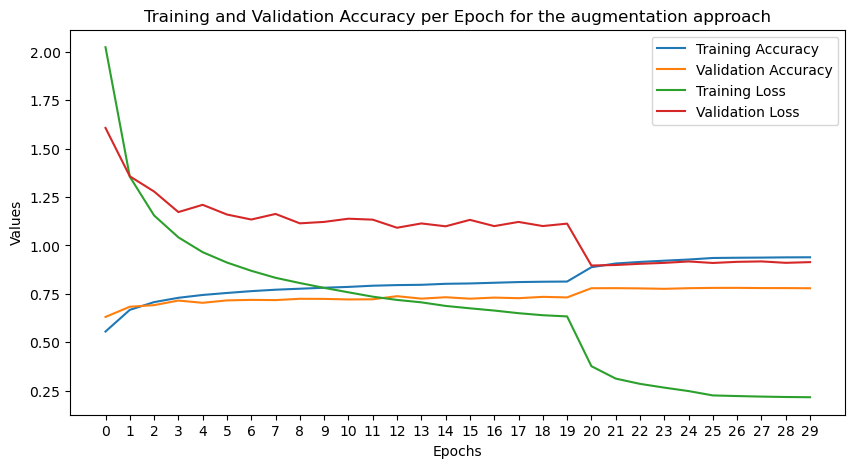

In [18]:
# read training progress data
df_epoch_acc = pd.read_csv('./results/epoch_acc_train_val_augmented.csv')

# visualize training progress data
plt.figure(figsize=(10, 5))

# plot the data
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_train'], label='Training Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_val'], label='Validation Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_train'], label='Training Loss')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_val'], label='Validation Loss')

# add titles and labels
plt.title('Training and Validation Accuracy per Epoch for the augmentation approach')
plt.xlabel('Epochs')
plt.ylabel('Values')

# display the legend
plt.legend()

# set x-axis ticks to show integers only
plt.xticks(range(df_epoch_acc['epoch'].min(), df_epoch_acc['epoch'].max()+1))

# save the figure as a PNG file
plt.savefig('./results/training_augmented.png', format='png', dpi=300)

# save the figure as a SVG vector graphic
plt.savefig('./results/training_augmented.svg', format='svg')

plt.show()

The next code block calculates the final accuracy on the test set.

In [6]:
start_time = time.time()

filename = './results/resnet18_augmentation/resnet18_augmentation_weights_best_acc.tar'
model_name = 'resnet18'
        
# load the model
model = pytorch_models[model_name](num_classes=1081)

# Load model weights and set to evaluation mode
load_model(model, filename=filename, use_gpu=use_gpu)
model.eval()
if use_gpu and torch.cuda.is_available():
    model.cuda()

# collect softmax outputs
softmax_outputs = []
labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        if use_gpu and torch.cuda.is_available():
            inputs = inputs.cuda()

        outputs = model(inputs)
        softmax_outputs.append(outputs.cpu().numpy())
        labels.append(targets.cpu().numpy())

softmax_outputs = np.concatenate(softmax_outputs, axis=0)
labels = np.concatenate(labels, axis=0)

# convert averaged softmax outputs to predicted classes
_, predictions = torch.max(torch.tensor(softmax_outputs), 1)

# calculate accuracy
correct = (predictions.numpy() == labels).sum()
total = labels.size
average_accuracy = correct / total

# calculate per-class accuracy
cm = confusion_matrix(labels, predictions.numpy())
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# count classes with over 90% accuracy
count_over_90 = np.sum(per_class_accuracy > 0.9)
count_under_90 = len(per_class_accuracy) - count_over_90

# print results
print(f'Accuracy for the augmentation model: {average_accuracy}')
print(f'Number of classes with accuracy over 90%: {count_over_90}')
print(f'Number of classes with accuracy under 90%: {count_under_90}')

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Accuracy for the augmentation model: 0.777563546386452
Number of classes with accuracy over 90%: 94
Number of classes with accuracy under 90%: 987
total time taken: 0h 0m 46.70s


## Oversampling and Undersampling of input data <a id="input_sampling"></a>

Another approach for improving model accuracy is oversampling of underrepresented classes and undersampling of overrepresented classes by changing the DataLoader. A probability is used to load the images from the dataset. The probability in this approach is defined as the inverse of the number of images per class (weight = 1 / number of images per class).

This approach can be controlled by the additional boolean parameter *weighted_sampler*.

In [39]:
start_time = time.time()

# execute command line call
root_folder = '../PlantNet-300K-dataset/images'
command = f'run main.py --lr=0.01 --batch_size=32 --mu=0.0001 --n_epochs=30 --epoch_decay 20 25 --k 1 3 5 10 --model=resnet18 --pretrained --seed=4 --image_size=256 --crop_size=224 --weighted_sampler --root={root_folder} --save_name_xp=resnet18_weighted_sampler'
get_ipython().run_line_magic('time', command)

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Seed:	 4


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



USING GPU
args.k :  [1, 3, 5, 10]


val:   0%|          | 0/973 [00:00<?, ?it/s]/home/paulb001/PlantNet-300K/epoch.py:79: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

epoch:   3%|▎         | 1/30 [07:12<3:28:52, 432.17s/it]


epoch 0 took 432.17
loss_train : 1.970397743049536
loss_val : 2.5816926796740467
acc_train : 0.5773114754098361 / topk_acc_train : {1: 0.5773114754098361, 3: 0.7228647540983607, 5: 0.7758811475409836, 10: 0.8344467213114755}
acc_val : 0.3617841763609487 / topk_acc_val : {1: 0.3617841763609487, 3: 0.6297319879169613, 5: 0.7267497911176811, 10: 0.8230927437495983} / avgk_acc_val : {1: 0.3959123336975384, 3: 0.6421042483450093, 5: 0.7386400154251559, 10: 0.8369432482807379}


epoch:   7%|▋         | 2/30 [14:19<3:20:14, 429.08s/it]


epoch 1 took 426.93
loss_train : 0.8558738521883676
loss_val : 2.4513334653995655
acc_train : 0.7803032786885246 / topk_acc_train : {1: 0.7803032786885246, 3: 0.8998565573770492, 5: 0.9322868852459016, 10: 0.9601639344262295}
acc_val : 0.3939841892152452 / topk_acc_val : {1: 0.3939841892152452, 3: 0.6716369946654669, 5: 0.7646378301947426, 10: 0.8494119159329006} / avgk_acc_val : {1: 0.42194228420849667, 3: 0.6752361976990809, 5: 0.7710007069863102, 10: 0.8654797866186773}


epoch:  10%|█         | 3/30 [21:20<3:11:26, 425.43s/it]


epoch 2 took 421.09
loss_train : 0.6386955574922976
loss_val : 2.2173145202452265
acc_train : 0.8286926229508197 / topk_acc_train : {1: 0.8286926229508197, 3: 0.9317827868852459, 5: 0.9564795081967213, 10: 0.9758524590163934}
acc_val : 0.45337103926987593 / topk_acc_val : {1: 0.45337103926987593, 3: 0.7083038755704094, 5: 0.7956166848769202, 10: 0.8767594318400925} / avgk_acc_val : {1: 0.4758981939713349, 3: 0.7189086702230221, 5: 0.8071534160293078, 10: 0.8899350858024294}


epoch:  13%|█▎        | 4/30 [28:04<3:00:43, 417.07s/it]


epoch 3 took 404.26
loss_train : 0.5298297282167616
loss_val : 2.174415412876341
acc_train : 0.8574836065573771 / topk_acc_train : {1: 0.8574836065573771, 3: 0.9467049180327869, 5: 0.9667540983606557, 10: 0.9820327868852459}
acc_val : 0.441994986824346 / topk_acc_val : {1: 0.441994986824346, 3: 0.7204190500674851, 5: 0.8074747734430233, 10: 0.8817726074940548} / avgk_acc_val : {1: 0.4689247380937078, 3: 0.7364869207532618, 5: 0.8220644000257086, 10: 0.8999293013689826}


epoch:  17%|█▋        | 5/30 [34:56<2:53:04, 415.40s/it]


epoch 4 took 412.43
loss_train : 0.46262766794591814
loss_val : 2.0268189962876675
acc_train : 0.8736721311475409 / topk_acc_train : {1: 0.8736721311475409, 3: 0.9564139344262295, 5: 0.9733196721311476, 10: 0.9860573770491803}
acc_val : 0.47310238447200975 / topk_acc_val : {1: 0.47310238447200975, 3: 0.7527797416286394, 5: 0.8374252844013111, 10: 0.9021466675236197} / avgk_acc_val : {1: 0.4954367247252394, 3: 0.7726074940548878, 5: 0.8531396619320007, 10: 0.9169612442959059}


epoch:  20%|██        | 6/30 [42:06<2:48:04, 420.20s/it]


epoch 5 took 429.51
loss_train : 0.41257520875031595
loss_val : 1.962989460661578
acc_train : 0.8875737704918033 / topk_acc_train : {1: 0.8875737704918033, 3: 0.9626188524590163, 5: 0.9775696721311475, 10: 0.9882131147540983}
acc_val : 0.49447265248409283 / topk_acc_val : {1: 0.49447265248409283, 3: 0.766405295970178, 5: 0.8408316729866958, 10: 0.9009897808342439} / avgk_acc_val : {1: 0.5182852368404139, 3: 0.7768494119159329, 5: 0.852400539880455, 10: 0.915225914261842}


epoch:  23%|██▎       | 7/30 [49:12<2:41:51, 422.23s/it]


epoch 6 took 426.42
loss_train : 0.38358542733607814
loss_val : 1.995566865789547
acc_train : 0.8946106557377049 / topk_acc_train : {1: 0.8946106557377049, 3: 0.9663811475409836, 5: 0.9801680327868852, 10: 0.9896434426229508}
acc_val : 0.48692075326177775 / topk_acc_val : {1: 0.48692075326177775, 3: 0.7650234590912013, 5: 0.8344687961951283, 10: 0.8970692203869143} / avgk_acc_val : {1: 0.5119544957902179, 3: 0.775981746898901, 5: 0.8507616170705058, 10: 0.9152580500032136}


epoch:  27%|██▋       | 8/30 [55:56<2:32:38, 416.31s/it]


epoch 7 took 403.64
loss_train : 0.36881335763209905
loss_val : 1.9506057951553368
acc_train : 0.898672131147541 / topk_acc_train : {1: 0.898672131147541, 3: 0.9683401639344262, 5: 0.9813811475409836, 10: 0.9903565573770492}
acc_val : 0.4980718555177068 / topk_acc_val : {1: 0.4980718555177068, 3: 0.7724146796066585, 5: 0.8422456456070442, 10: 0.8999614371103541} / avgk_acc_val : {1: 0.522816376373803, 3: 0.788354007326949, 5: 0.8576708014653898, 10: 0.9171861944855068}


epoch:  30%|███       | 9/30 [1:02:39<2:24:14, 412.12s/it]


epoch 8 took 402.90
loss_train : 0.34577075796468615
loss_val : 1.946566078704571
acc_train : 0.9053770491803279 / topk_acc_train : {1: 0.9053770491803279, 3: 0.9707008196721312, 5: 0.9829590163934426, 10: 0.9913155737704918}
acc_val : 0.5085802429462047 / topk_acc_val : {1: 0.5085802429462047, 3: 0.7620026994022752, 5: 0.8358184973327335, 10: 0.8979690211453178} / avgk_acc_val : {1: 0.5319107911819526, 3: 0.7849154830001928, 5: 0.8539751912076612, 10: 0.9147438781412687}


epoch:  33%|███▎      | 10/30 [1:09:46<2:18:58, 416.91s/it]


epoch 9 took 427.63
loss_train : 0.33451221146447835
loss_val : 1.817799589148274
acc_train : 0.9084016393442623 / topk_acc_train : {1: 0.9084016393442623, 3: 0.9722991803278689, 5: 0.9836639344262295, 10: 0.9919098360655738}
acc_val : 0.5336139854746449 / topk_acc_val : {1: 0.5336139854746449, 3: 0.7899607943955267, 5: 0.8584099235169356, 10: 0.9132977697795488} / avgk_acc_val : {1: 0.5543415386592969, 3: 0.8076675878912527, 5: 0.87608458127129, 10: 0.9289478758274954}


epoch:  37%|███▋      | 11/30 [1:16:30<2:10:44, 412.88s/it]


epoch 10 took 403.74
loss_train : 0.3289153738829805
loss_val : 1.8920671996265772
acc_train : 0.9104426229508197 / topk_acc_train : {1: 0.9104426229508197, 3: 0.9729426229508197, 5: 0.9840409836065573, 10: 0.9919672131147541}
acc_val : 0.5040812391541872 / topk_acc_val : {1: 0.5040812391541872, 3: 0.7812841442252073, 5: 0.8506652098463912, 10: 0.9067742142811235} / avgk_acc_val : {1: 0.5282473166655954, 3: 0.7980590012211581, 5: 0.8680827816697732, 10: 0.9252522655697667}


epoch:  40%|████      | 12/30 [1:23:36<2:05:02, 416.82s/it]


epoch 11 took 425.84
loss_train : 0.3139694932257465
loss_val : 1.8589822910572766
acc_train : 0.9145122950819672 / topk_acc_train : {1: 0.9145122950819672, 3: 0.9746926229508197, 5: 0.9855737704918033, 10: 0.9927745901639344}
acc_val : 0.5340960215952182 / topk_acc_val : {1: 0.5340960215952182, 3: 0.7817983160871521, 5: 0.8477087216402083, 10: 0.9067742142811235} / avgk_acc_val : {1: 0.5576515200205668, 3: 0.797352014910984, 5: 0.8642264927051867, 10: 0.9218780127257535}


epoch:  43%|████▎     | 13/30 [1:30:22<1:57:12, 413.68s/it]


epoch 12 took 406.44
loss_train : 0.30674909775762
loss_val : 1.979990836401535
acc_train : 0.9159631147540983 / topk_acc_train : {1: 0.9159631147540983, 3: 0.9758688524590164, 5: 0.9862418032786885, 10: 0.9929672131147541}
acc_val : 0.5156501060479465 / topk_acc_val : {1: 0.5156501060479465, 3: 0.7723825438652869, 5: 0.844205925830709, 10: 0.902917925316537} / avgk_acc_val : {1: 0.5343209717848191, 3: 0.7803522077254322, 5: 0.8481907577607816, 10: 0.9091843948839899}


epoch:  47%|████▋     | 14/30 [1:37:19<1:50:31, 414.47s/it]


epoch 13 took 416.31
loss_train : 0.2993453661666876
loss_val : 1.9064995215385538
acc_train : 0.9177295081967213 / topk_acc_train : {1: 0.9177295081967213, 3: 0.9768811475409837, 5: 0.9867090163934427, 10: 0.9932991803278689}
acc_val : 0.5245517064078669 / topk_acc_val : {1: 0.5245517064078669, 3: 0.779355999742914, 5: 0.8464554277267177, 10: 0.9055209203676329} / avgk_acc_val : {1: 0.546628960730124, 3: 0.7960344495147503, 5: 0.861109325792146, 10: 0.9191464747091715}


epoch:  50%|█████     | 15/30 [1:44:11<1:43:27, 413.83s/it]


epoch 14 took 412.35
loss_train : 0.3013588595951654
loss_val : 1.78796051326112
acc_train : 0.917438524590164 / topk_acc_train : {1: 0.917438524590164, 3: 0.9764754098360656, 5: 0.9863606557377049, 10: 0.9931352459016394}
acc_val : 0.5493926344880776 / topk_acc_val : {1: 0.5493926344880776, 3: 0.7937206761359985, 5: 0.8576708014653898, 10: 0.9106626389870814} / avgk_acc_val : {1: 0.569445337103927, 3: 0.8143518220965358, 5: 0.872549649720419, 10: 0.9255093515007391}


epoch:  53%|█████▎    | 16/30 [1:51:10<1:36:56, 415.44s/it]


epoch 15 took 419.18
loss_train : 0.29421558862103486
loss_val : 1.752914561656277
acc_train : 0.919672131147541 / topk_acc_train : {1: 0.919672131147541, 3: 0.977516393442623, 5: 0.9869877049180328, 10: 0.9934426229508196}
acc_val : 0.5448293592133171 / topk_acc_val : {1: 0.5448293592133171, 3: 0.8044218780127258, 5: 0.8678578314801723, 10: 0.9193071534160293} / avgk_acc_val : {1: 0.5656533196220837, 3: 0.8250851597146346, 5: 0.885500353493155, 10: 0.934732309274375}


epoch:  57%|█████▋    | 17/30 [1:58:01<1:29:43, 414.11s/it]


epoch 16 took 411.02
loss_train : 0.2892513516660025
loss_val : 1.8436005781462164
acc_train : 0.9207008196721311 / topk_acc_train : {1: 0.9207008196721311, 3: 0.9778688524590164, 5: 0.9875737704918033, 10: 0.9937131147540984}
acc_val : 0.5402660839385565 / topk_acc_val : {1: 0.5402660839385565, 3: 0.7926601966707372, 5: 0.8593739957580822, 10: 0.9118837971592004} / avgk_acc_val : {1: 0.5591297641236583, 3: 0.806060800822675, 5: 0.8725817854617905, 10: 0.9257664374317115}


epoch:  60%|██████    | 18/30 [2:05:15<1:23:59, 419.97s/it]


epoch 17 took 433.60
loss_train : 0.28414132110266344
loss_val : 1.8436796727126519
acc_train : 0.9224426229508197 / topk_acc_train : {1: 0.9224426229508197, 3: 0.9783770491803279, 5: 0.9875983606557377, 10: 0.993655737704918}
acc_val : 0.5341924288193328 / topk_acc_val : {1: 0.5341924288193328, 3: 0.78713284915483, 5: 0.8528504402596568, 10: 0.9072883861430683} / avgk_acc_val : {1: 0.5584549135548557, 3: 0.8064785654605052, 5: 0.867375795359599, 10: 0.9221029629153544}


epoch:  63%|██████▎   | 19/30 [2:12:16<1:17:02, 420.20s/it]


epoch 18 took 420.74
loss_train : 0.2775291210286718
loss_val : 1.8214973676106567
acc_train : 0.9236393442622951 / topk_acc_train : {1: 0.9236393442622951, 3: 0.9790450819672131, 5: 0.9880901639344263, 10: 0.9939713114754098}
acc_val : 0.5395912333697538 / topk_acc_val : {1: 0.5395912333697538, 3: 0.7968699787904107, 5: 0.8618484478436917, 10: 0.9133620412622919} / avgk_acc_val : {1: 0.5607044154508645, 3: 0.8145125008033935, 5: 0.8743171154958544, 10: 0.9253165370525098}


epoch:  67%|██████▋   | 20/30 [2:18:59<1:09:11, 415.15s/it]


epoch 19 took 403.37
loss_train : 0.2754682570005447
loss_val : 1.79635711431258
acc_train : 0.9250655737704918 / topk_acc_train : {1: 0.9250655737704918, 3: 0.9791926229508197, 5: 0.9881147540983607, 10: 0.9941844262295082}
acc_val : 0.5471431325920689 / topk_acc_val : {1: 0.5471431325920689, 3: 0.7976091008419565, 5: 0.8610771900507744, 10: 0.9138440773828652} / avgk_acc_val : {1: 0.5663603059322578, 3: 0.8100777684941192, 5: 0.8738350793752812, 10: 0.9277909891381194}
Switching lr to 0.001


epoch:  70%|███████   | 21/30 [2:26:02<1:02:38, 417.60s/it]


epoch 20 took 423.32
loss_train : 0.14831651712008942
loss_val : 1.2973630355341443
acc_train : 0.9589877049180328 / topk_acc_train : {1: 0.9589877049180328, 3: 0.9906270491803278, 5: 0.9949016393442623, 10: 0.9973811475409836}
acc_val : 0.6592647342374188 / topk_acc_val : {1: 0.6592647342374188, 3: 0.8669258949803972, 5: 0.9091843948839899, 10: 0.9452728324442445} / avgk_acc_val : {1: 0.6752683334404525, 3: 0.8928273025258693, 5: 0.9292692332412109, 10: 0.9601195449579022}


epoch:  73%|███████▎  | 22/30 [2:32:55<55:28, 416.10s/it]  


epoch 21 took 412.60
loss_train : 0.11658092738976478
loss_val : 1.2545759493002184
acc_train : 0.9681598360655738 / topk_acc_train : {1: 0.9681598360655738, 3: 0.9935245901639345, 5: 0.9964713114754098, 10: 0.998327868852459}
acc_val : 0.6736936821132463 / topk_acc_val : {1: 0.6736936821132463, 3: 0.8732566360305932, 5: 0.9122372903142876, 10: 0.947683013047111} / avgk_acc_val : {1: 0.687608458127129, 3: 0.8981296998521756, 5: 0.9325470788611093, 10: 0.9616299248023652}


epoch:  77%|███████▋  | 23/30 [2:39:56<48:42, 417.47s/it]


epoch 22 took 420.67
loss_train : 0.10657135582489186
loss_val : 1.25843824731347
acc_train : 0.9713237704918033 / topk_acc_train : {1: 0.9713237704918033, 3: 0.994094262295082, 5: 0.9967991803278689, 10: 0.9985122950819673}
acc_val : 0.6692589498039719 / topk_acc_val : {1: 0.6692589498039719, 3: 0.8750241018060286, 5: 0.9147117423998972, 10: 0.9480686419435697} / avgk_acc_val : {1: 0.68307731859374, 3: 0.8983546500417765, 5: 0.9336075583263705, 10: 0.9622405038884247}


epoch:  80%|████████  | 24/30 [2:46:48<41:36, 416.03s/it]


epoch 23 took 412.67
loss_train : 0.10172165824623938
loss_val : 1.228830018130595
acc_train : 0.9725532786885246 / topk_acc_train : {1: 0.9725532786885246, 3: 0.9945409836065574, 5: 0.9971311475409836, 10: 0.9985204918032787}
acc_val : 0.6762645414229707 / topk_acc_val : {1: 0.6762645414229707, 3: 0.8794909698566746, 5: 0.9169612442959059, 10: 0.9484864065813998} / avgk_acc_val : {1: 0.6922038691432612, 3: 0.9027893823510509, 5: 0.9361784176360949, 10: 0.9633652548364291}


epoch:  83%|████████▎ | 25/30 [2:53:54<34:54, 419.00s/it]


epoch 24 took 425.92
loss_train : 0.0946866993796997
loss_val : 1.2270209756775647
acc_train : 0.9747377049180328 / topk_acc_train : {1: 0.9747377049180328, 3: 0.9952540983606557, 5: 0.9974303278688524, 10: 0.9987950819672131}
acc_val : 0.6776463783019474 / topk_acc_val : {1: 0.6776463783019474, 3: 0.8799730059772479, 5: 0.9160935792788739, 10: 0.9485185423227714} / avgk_acc_val : {1: 0.6950639501253294, 3: 0.9027251108683078, 5: 0.9360498746706086, 10: 0.9629474901985989}
Switching lr to 0.0001


epoch:  87%|████████▋ | 26/30 [3:01:07<28:12, 423.21s/it]


epoch 25 took 433.02
loss_train : 0.09107916608705295
loss_val : 1.2057927182488481
acc_train : 0.9756967213114754 / topk_acc_train : {1: 0.9756967213114754, 3: 0.9954672131147541, 5: 0.9975327868852459, 10: 0.9988483606557377}
acc_val : 0.6846198341795745 / topk_acc_val : {1: 0.6846198341795745, 3: 0.8810013497011376, 5: 0.9179253165370526, 10: 0.9496754290121473} / avgk_acc_val : {1: 0.7003984831930072, 3: 0.9050388842470596, 5: 0.937463847290957, 10: 0.9639758339224886}


epoch:  90%|█████████ | 27/30 [3:08:05<21:04, 421.53s/it]


epoch 26 took 417.62
loss_train : 0.08785403050542863
loss_val : 1.1911939944566032
acc_train : 0.9770081967213115 / topk_acc_train : {1: 0.9770081967213115, 3: 0.9959918032786885, 5: 0.9977827868852459, 10: 0.9989631147540984}
acc_val : 0.6880904942477023 / topk_acc_val : {1: 0.6880904942477023, 3: 0.8828009512179446, 5: 0.9190822032264284, 10: 0.9504788225464361} / avgk_acc_val : {1: 0.702358763416672, 3: 0.9064207211260363, 5: 0.9387814126871907, 10: 0.9643293270775757}


epoch:  93%|█████████▎| 28/30 [3:14:53<13:55, 417.51s/it]


epoch 27 took 408.14
loss_train : 0.08946469202590031
loss_val : 1.1929958344364362
acc_train : 0.9765614754098361 / topk_acc_train : {1: 0.9765614754098361, 3: 0.9953852459016393, 5: 0.9975860655737705, 10: 0.9989262295081968}
acc_val : 0.6871264220065557 / topk_acc_val : {1: 0.6871264220065557, 3: 0.8826081367697153, 5: 0.9183109454335111, 10: 0.9504788225464361} / avgk_acc_val : {1: 0.7031621569509608, 3: 0.9062600424191786, 5: 0.9385885982389613, 10: 0.9639115624397455}


epoch:  97%|█████████▋| 29/30 [3:21:37<06:53, 413.30s/it]


epoch 28 took 403.48
loss_train : 0.08686518830827224
loss_val : 1.1942463787617508
acc_train : 0.9769590163934426 / topk_acc_train : {1: 0.9769590163934426, 3: 0.9957459016393443, 5: 0.9977622950819672, 10: 0.9988852459016393}
acc_val : 0.6897615527990231 / topk_acc_val : {1: 0.6897615527990231, 3: 0.8816440645285687, 5: 0.9191143389678, 10: 0.9509287229256379} / avgk_acc_val : {1: 0.7051545729159971, 3: 0.9065813998328941, 5: 0.9388778199113054, 10: 0.9640722411466033}


epoch: 100%|██████████| 30/30 [3:28:35<00:00, 417.18s/it]



epoch 29 took 418.50
loss_train : 0.08732877904176663
loss_val : 1.1897290343487705
acc_train : 0.9770081967213115 / topk_acc_train : {1: 0.9770081967213115, 3: 0.9957295081967213, 5: 0.9977336065573771, 10: 0.9989467213114754}
acc_val : 0.6913683398676007 / topk_acc_val : {1: 0.6913683398676007, 3: 0.8836043447522335, 5: 0.9193071534160293, 10: 0.9505752297705508} / avgk_acc_val : {1: 0.705090301433254, 3: 0.906806350022495, 5: 0.938620733980333, 10: 0.9640722411466033}



test:   0%|          | 0/973 [00:00<?, ?it/s]/home/paulb001/PlantNet-300K/epoch.py:154: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

test: 100%|██████████| 973/973 [00:46<00:00, 21.01it/s]


CPU times: user 1h 24min 53s, sys: 23min 53s, total: 1h 48min 47s
Wall time: 3h 29min 28s
total time taken: 3h 29m 28.33s


In order to be able to compare training progress between different training cycles, the training data is renamed in the next code block.

In [40]:
# rename the file
current_file_path = './results/epoch_acc_train_val.csv'
new_file_path = './results/epoch_acc_train_val_weighted_sampler.csv'
os.rename(current_file_path, new_file_path)

The code block below visualizes the training progress.

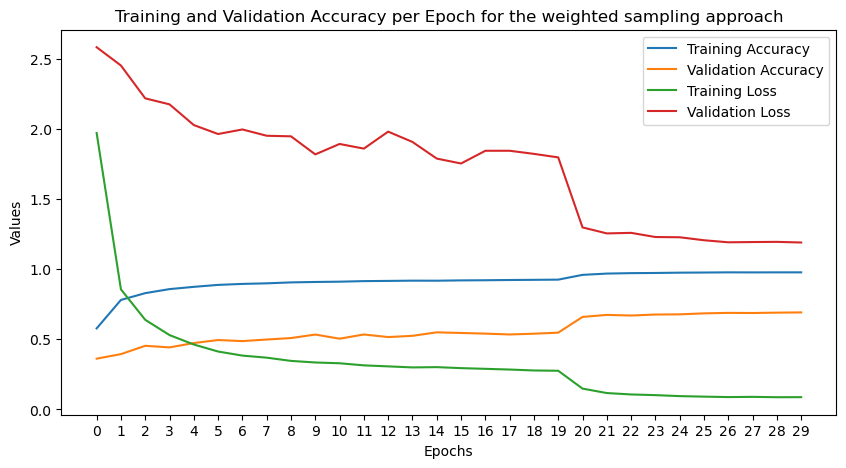

In [19]:
# read training progress data
df_epoch_acc = pd.read_csv('./results/epoch_acc_train_val_weighted_sampler.csv')

# visualize training progress data
plt.figure(figsize=(10, 5))

# plot the data
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_train'], label='Training Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_val'], label='Validation Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_train'], label='Training Loss')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_val'], label='Validation Loss')

# add titles and labels
plt.title('Training and Validation Accuracy per Epoch for the weighted sampling approach')
plt.xlabel('Epochs')
plt.ylabel('Values')

# display the legend
plt.legend()

# set x-axis ticks to show integers only
plt.xticks(range(df_epoch_acc['epoch'].min(), df_epoch_acc['epoch'].max()+1))

# save the figure as a PNG file
plt.savefig('./results/training_weighted_sampler.png', format='png', dpi=300)

# save the figure as a SVG vector graphic
plt.savefig('./results/training_weighted_sampler.svg', format='svg')

plt.show()

The next code block calculates the final accuracy on the test set.

In [8]:
start_time = time.time()

filename = './results/resnet18_weighted_sampler/resnet18_weighted_sampler_weights_best_acc.tar'
model_name = 'resnet18'
        
# load the model
model = pytorch_models[model_name](num_classes=1081)

# Load model weights and set to evaluation mode
load_model(model, filename=filename, use_gpu=use_gpu)
model.eval()
if use_gpu and torch.cuda.is_available():
    model.cuda()

# collect softmax outputs
softmax_outputs = []
labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        if use_gpu and torch.cuda.is_available():
            inputs = inputs.cuda()

        outputs = model(inputs)
        softmax_outputs.append(outputs.cpu().numpy())
        labels.append(targets.cpu().numpy())

softmax_outputs = np.concatenate(softmax_outputs, axis=0)
labels = np.concatenate(labels, axis=0)

# convert averaged softmax outputs to predicted classes
_, predictions = torch.max(torch.tensor(softmax_outputs), 1)

# calculate accuracy
correct = (predictions.numpy() == labels).sum()
total = labels.size
average_accuracy = correct / total

# calculate per-class accuracy
cm = confusion_matrix(labels, predictions.numpy())
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# count classes with over 90% accuracy
count_over_90 = np.sum(per_class_accuracy > 0.9)
count_under_90 = len(per_class_accuracy) - count_over_90

# print results
print(f'Accuracy for the weighted sampler model: {average_accuracy}')
print(f'Number of classes with accuracy over 90%: {count_over_90}')
print(f'Number of classes with accuracy under 90%: {count_under_90}')

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Accuracy for the weighted sampler model: 0.6909605064430091
Number of classes with accuracy over 90%: 83
Number of classes with accuracy under 90%: 998
total time taken: 0h 0m 46.97s


## Changing the Loss Function <a id="weighted_sampling"></a>

This chapter shows the effect of a changed loss function. Since CrossEntropy was previously used, it was decided to use weighted CrossEntropy as a second loss function due to similar implementation. As before, the weights are given as the inverse of the number of images, so that underrepresented classes are overweighted and overrepresented classes are underweighted.

The main idea of using a weighted loss function is similar to the approach mentioned before, but it is not identical. This approach also uses the class_weight based on the inverse of the number of images in a class, but instead of changing the input to the model directly, the loss function weighs the input. The model still uses the same distribution of data as in the standard process for training, but it weighs the training results differently based on the class an image belongs to. 

This approach can be controlled by the additional boolean parameter *weighted_crossentropy*.

In [42]:
start_time = time.time()

# execute command line call
root_folder = '../PlantNet-300K-dataset/images'
command = f'run main.py --lr=0.01 --batch_size=32 --mu=0.0001 --n_epochs=30 --epoch_decay 20 25 --k 1 3 5 10 --model=resnet18 --pretrained --seed=4 --image_size=256 --crop_size=224 --weighted_crossentropy --root={root_folder} --save_name_xp=resnet18_weighted_crossentropy'
get_ipython().run_line_magic('time', command)

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Seed:	 4


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



USING GPU
args.k :  [1, 3, 5, 10]


val:   0%|          | 0/973 [00:00<?, ?it/s]/home/paulb001/PlantNet-300K/epoch.py:79: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

epoch:   3%|▎         | 1/30 [07:03<3:24:35, 423.28s/it]


epoch 0 took 423.28
loss_train : 6.873443319127042
loss_val : 6.812507858246933
acc_train : 0.0008442622950819672 / topk_acc_train : {1: 0.0008442622950819672, 3: 0.003795081967213115, 5: 0.007565573770491803, 10: 0.020086065573770493}
acc_val : 0.001896008740921653 / topk_acc_val : {1: 0.001896008740921653, 3: 0.009994215566553121, 5: 0.02278424063243139, 10: 0.05900122115817212} / avgk_acc_val : {1: 0.011504595411016132, 3: 0.031717976733723244, 5: 0.047657304454013755, 10: 0.08422777813484157}


epoch:   7%|▋         | 2/30 [13:46<3:12:06, 411.66s/it]


epoch 1 took 403.52
loss_train : 6.388283703503554
loss_val : 6.325975383995982
acc_train : 0.008934426229508196 / topk_acc_train : {1: 0.008934426229508196, 3: 0.034184426229508194, 5: 0.06144672131147541, 10: 0.12590573770491803}
acc_val : 0.018992223150588083 / topk_acc_val : {1: 0.018992223150588083, 3: 0.07256250401696768, 5: 0.12687190693489298, 10: 0.22957773635837778} / avgk_acc_val : {1: 0.04913554855710521, 3: 0.12442959059065492, 5: 0.17764637830194743, 10: 0.2608779484542708}


epoch:  10%|█         | 3/30 [20:28<3:03:11, 407.09s/it]


epoch 2 took 401.64
loss_train : 5.851721433627518
loss_val : 5.761795017209073
acc_train : 0.03320081967213115 / topk_acc_train : {1: 0.03320081967213115, 3: 0.10409426229508197, 5: 0.16612704918032786, 10: 0.27884426229508197}
acc_val : 0.06080082267497911 / topk_acc_val : {1: 0.06080082267497911, 3: 0.17478629731987916, 5: 0.2537759496111575, 10: 0.38170833601131177} / avgk_acc_val : {1: 0.10344495147503052, 3: 0.21675557555112795, 5: 0.28533324763802304, 10: 0.39186323028472264}


epoch:  13%|█▎        | 4/30 [27:10<2:55:37, 405.29s/it]


epoch 3 took 402.54
loss_train : 5.329204437239848
loss_val : 5.402654037799365
acc_train : 0.07345901639344263 / topk_acc_train : {1: 0.07345901639344263, 3: 0.1902377049180328, 5: 0.27085245901639343, 10: 0.396}
acc_val : 0.10103477087216402 / topk_acc_val : {1: 0.10103477087216402, 3: 0.23275917475416158, 5: 0.3207468346294749, 10: 0.4449836107719005} / avgk_acc_val : {1: 0.14721383122308632, 3: 0.27289671572723184, 5: 0.34741949996786425, 10: 0.4574522784240632}


epoch:  17%|█▋        | 5/30 [34:08<2:50:41, 409.64s/it]


epoch 4 took 417.36
loss_train : 4.877986499795384
loss_val : 5.038532100709868
acc_train : 0.11488114754098361 / topk_acc_train : {1: 0.11488114754098361, 3: 0.2661065573770492, 5: 0.35408196721311475, 10: 0.4790409836065574}
acc_val : 0.15187351372196156 / topk_acc_val : {1: 0.15187351372196156, 3: 0.32685262549007005, 5: 0.4164149366925895, 10: 0.5405553056109005} / avgk_acc_val : {1: 0.20235876341667203, 3: 0.352689761552799, 5: 0.43074747734430235, 10: 0.5461147888681792}


epoch:  20%|██        | 6/30 [41:11<2:45:44, 414.36s/it]


epoch 5 took 423.51
loss_train : 4.462446261318508
loss_val : 4.779489126102424
acc_train : 0.14939754098360655 / topk_acc_train : {1: 0.14939754098360655, 3: 0.32425, 5: 0.4197213114754098, 10: 0.5486680327868853}
acc_val : 0.1708978726139212 / topk_acc_val : {1: 0.1708978726139212, 3: 0.35902050260299506, 5: 0.45668102063114596, 10: 0.582974484221351} / avgk_acc_val : {1: 0.21932643486085224, 3: 0.384214923838293, 5: 0.4696959958866251, 10: 0.590172890288579}


epoch:  23%|██▎       | 7/30 [48:07<2:39:02, 414.88s/it]


epoch 6 took 415.96
loss_train : 4.108999635387067
loss_val : 4.571718732025397
acc_train : 0.1845655737704918 / topk_acc_train : {1: 0.1845655737704918, 3: 0.3779139344262295, 5: 0.47624180327868854, 10: 0.602282786885246}
acc_val : 0.2171412044475866 / topk_acc_val : {1: 0.2171412044475866, 3: 0.4111768108490263, 5: 0.5061700623433383, 10: 0.6273218073140947} / avgk_acc_val : {1: 0.2604280480750691, 3: 0.4308117488270454, 5: 0.5172247573751526, 10: 0.633781091329777}


epoch:  27%|██▋       | 8/30 [55:17<2:33:51, 419.62s/it]


epoch 7 took 429.77
loss_train : 3.8161675106628494
loss_val : 4.425095806764477
acc_train : 0.20720081967213114 / topk_acc_train : {1: 0.20720081967213114, 3: 0.4166762295081967, 5: 0.51625, 10: 0.6402090163934426}
acc_val : 0.22678192685905263 / topk_acc_val : {1: 0.22678192685905263, 3: 0.43158300661996274, 5: 0.5289864387171412, 10: 0.65184137798059} / avgk_acc_val : {1: 0.26653383893566424, 3: 0.45096085866700947, 5: 0.5413908348865608, 10: 0.661482100392056}


epoch:  30%|███       | 9/30 [1:02:11<2:26:12, 417.74s/it]


epoch 8 took 413.60
loss_train : 3.5566513142885654
loss_val : 4.344660037338979
acc_train : 0.2339795081967213 / topk_acc_train : {1: 0.2339795081967213, 3: 0.45379508196721313, 5: 0.5551598360655737, 10: 0.675905737704918}
acc_val : 0.24988752490519955 / topk_acc_val : {1: 0.24988752490519955, 3: 0.4696638601452536, 5: 0.5659425412944277, 10: 0.6873513721961566} / avgk_acc_val : {1: 0.2915675814641044, 3: 0.4839321293142233, 5: 0.5801465389806543, 10: 0.6980525740728839}


epoch:  33%|███▎      | 10/30 [1:09:22<2:20:39, 421.95s/it]


epoch 9 took 431.38
loss_train : 3.3071856757104086
loss_val : 4.0502204117461
acc_train : 0.2574467213114754 / topk_acc_train : {1: 0.2574467213114754, 3: 0.4879426229508197, 5: 0.5883975409836065, 10: 0.7055}
acc_val : 0.28044861494954687 / topk_acc_val : {1: 0.28044861494954687, 3: 0.5227199691496883, 5: 0.6210553377466418, 10: 0.7311202519442124} / avgk_acc_val : {1: 0.3308374574201427, 3: 0.538723568352722, 5: 0.6336204126229192, 10: 0.7441352271996915}


epoch:  37%|███▋      | 11/30 [1:16:18<2:13:02, 420.13s/it]


epoch 10 took 416.00
loss_train : 3.100939962997298
loss_val : 4.152317350232061
acc_train : 0.2771393442622951 / topk_acc_train : {1: 0.2771393442622951, 3: 0.5179303278688525, 5: 0.6176844262295081, 10: 0.7314918032786886}
acc_val : 0.24812005912976412 / topk_acc_val : {1: 0.24812005912976412, 3: 0.4881419114338968, 5: 0.5978854682177518, 10: 0.7177196477922746} / avgk_acc_val : {1: 0.28963943698181116, 3: 0.5049167684298477, 5: 0.6045697024230349, 10: 0.7256893116524198}


epoch:  40%|████      | 12/30 [1:22:55<2:03:56, 413.15s/it]


epoch 11 took 397.18
loss_train : 2.9173235032289186
loss_val : 4.035256601532791
acc_train : 0.29289754098360654 / topk_acc_train : {1: 0.29289754098360654, 3: 0.5381762295081968, 5: 0.6372213114754098, 10: 0.7479467213114754}
acc_val : 0.28427276817276176 / topk_acc_val : {1: 0.28427276817276176, 3: 0.5217558969085416, 5: 0.6195449579021788, 10: 0.7331769393919918} / avgk_acc_val : {1: 0.32662767530046916, 3: 0.5391091972491805, 5: 0.6318529468474837, 10: 0.7454206568545536}


epoch:  43%|████▎     | 13/30 [1:29:34<1:55:49, 408.80s/it]


epoch 12 took 398.80
loss_train : 2.7330774234027326
loss_val : 4.1195353832509785
acc_train : 0.30849590163934426 / topk_acc_train : {1: 0.30849590163934426, 3: 0.5577295081967213, 5: 0.6571598360655738, 10: 0.7651762295081967}
acc_val : 0.29269233241210874 / topk_acc_val : {1: 0.29269233241210874, 3: 0.5332604923195579, 5: 0.6325277974162864, 10: 0.7416286393727103} / avgk_acc_val : {1: 0.3322835657818626, 3: 0.5460826531268076, 5: 0.6394048460697989, 10: 0.7532296420078411}


epoch:  47%|████▋     | 14/30 [1:36:15<1:48:21, 406.35s/it]


epoch 13 took 400.66
loss_train : 2.599346160962943
loss_val : 3.956763239891686
acc_train : 0.32249180327868854 / topk_acc_train : {1: 0.32249180327868854, 3: 0.5749795081967213, 5: 0.6733155737704918, 10: 0.7782622950819672}
acc_val : 0.3336654026608394 / topk_acc_val : {1: 0.3336654026608394, 3: 0.5801786747220259, 5: 0.677742785526062, 10: 0.7781669773121666} / avgk_acc_val : {1: 0.3691111253936628, 3: 0.5964072241146603, 5: 0.6896330098335368, 10: 0.7937849476187415}


epoch:  50%|█████     | 15/30 [1:43:16<1:42:42, 410.85s/it]


epoch 14 took 421.29
loss_train : 2.467429200582136
loss_val : 4.05283883256922
acc_train : 0.3339098360655738 / topk_acc_train : {1: 0.3339098360655738, 3: 0.5918401639344262, 5: 0.6896967213114754, 10: 0.7927459016393442}
acc_val : 0.30766758789125265 / topk_acc_val : {1: 0.30766758789125265, 3: 0.5665531203804872, 5: 0.662349765409088, 10: 0.7692332412108748} / avgk_acc_val : {1: 0.3461019345716306, 3: 0.5712128028793624, 5: 0.6652741178738993, 10: 0.776335240053988}


epoch:  53%|█████▎    | 16/30 [1:50:23<1:37:00, 415.73s/it]


epoch 15 took 427.05
loss_train : 2.348928094621658
loss_val : 4.002585315026741
acc_train : 0.3435286885245902 / topk_acc_train : {1: 0.3435286885245902, 3: 0.6029590163934426, 5: 0.7000122950819672, 10: 0.8019467213114754}
acc_val : 0.3273025258692718 / topk_acc_val : {1: 0.3273025258692718, 3: 0.5778006298605309, 5: 0.6781926859052638, 10: 0.7790667780705701} / avgk_acc_val : {1: 0.36576900829102127, 3: 0.5962786811491742, 5: 0.6910469824538852, 10: 0.7926923324121088}


epoch:  57%|█████▋    | 17/30 [1:57:11<1:29:34, 413.44s/it]


epoch 16 took 408.13
loss_train : 2.2249989622670294
loss_val : 4.004571459144967
acc_train : 0.3569180327868852 / topk_acc_train : {1: 0.3569180327868852, 3: 0.6178893442622951, 5: 0.7143934426229508, 10: 0.8122172131147541}
acc_val : 0.33064464297191337 / topk_acc_val : {1: 0.33064464297191337, 3: 0.5819782762388328, 5: 0.6774214281123465, 10: 0.7788096921395976} / avgk_acc_val : {1: 0.36612250144610836, 3: 0.5982710971142104, 5: 0.6901793174368532, 10: 0.7928208753775949}


epoch:  60%|██████    | 18/30 [2:04:15<1:23:18, 416.58s/it]


epoch 17 took 423.87
loss_train : 2.1133670942078013
loss_val : 3.9717908000013957
acc_train : 0.3661229508196721 / topk_acc_train : {1: 0.3661229508196721, 3: 0.6315573770491804, 5: 0.7261885245901639, 10: 0.8217786885245901}
acc_val : 0.3291021273860788 / topk_acc_val : {1: 0.3291021273860788, 3: 0.6014846712513657, 5: 0.7009126550549521, 10: 0.8007905392377402} / avgk_acc_val : {1: 0.36856481779034644, 3: 0.6105469503181439, 5: 0.7056687447779421, 10: 0.8111061122180089}


epoch:  63%|██████▎   | 19/30 [2:11:01<1:15:46, 413.35s/it]


epoch 18 took 405.81
loss_train : 2.043064698930693
loss_val : 3.917918650395095
acc_train : 0.37706967213114756 / topk_acc_train : {1: 0.37706967213114756, 3: 0.6425655737704918, 5: 0.7366311475409836, 10: 0.8308565573770492}
acc_val : 0.3612057330162607 / topk_acc_val : {1: 0.3612057330162607, 3: 0.619030786040234, 5: 0.713799087344945, 10: 0.8085673886496562} / avgk_acc_val : {1: 0.39202390899158046, 3: 0.6313387749855389, 5: 0.7244360177389292, 10: 0.8226749791117681}


epoch:  67%|██████▋   | 20/30 [2:18:05<1:09:25, 416.55s/it]


epoch 19 took 424.02
loss_train : 1.9543184545672923
loss_val : 3.8435117464681223
acc_train : 0.3829631147540984 / topk_acc_train : {1: 0.3829631147540984, 3: 0.6472909836065573, 5: 0.7413073770491804, 10: 0.8350696721311476}
acc_val : 0.36136641172311845 / topk_acc_val : {1: 0.36136641172311845, 3: 0.6249116267112282, 5: 0.7250465968249887, 10: 0.8192685905263835} / avgk_acc_val : {1: 0.3948197184909056, 3: 0.6335561411401761, 5: 0.7264927051867086, 10: 0.8274632045761295}
Switching lr to 0.001


epoch:  70%|███████   | 21/30 [2:24:58<1:02:20, 415.64s/it]


epoch 20 took 413.51
loss_train : 1.2503538322542156
loss_val : 3.5307629449377336
acc_train : 0.48264344262295084 / topk_acc_train : {1: 0.48264344262295084, 3: 0.7348729508196721, 5: 0.8111926229508196, 10: 0.8822131147540984}
acc_val : 0.4669965936114146 / topk_acc_val : {1: 0.4669965936114146, 3: 0.720708271739829, 5: 0.7984767658589884, 10: 0.8711035413586992} / avgk_acc_val : {1: 0.4972041905006748, 3: 0.7432675621826595, 5: 0.8224178931807957, 10: 0.8953338903528505}


epoch:  73%|███████▎  | 22/30 [2:31:42<54:56, 412.04s/it]  


epoch 21 took 403.66
loss_train : 1.0480578442623083
loss_val : 3.6044101163652944
acc_train : 0.5200491803278688 / topk_acc_train : {1: 0.5200491803278688, 3: 0.7651844262295082, 5: 0.8354959016393443, 10: 0.8993893442622951}
acc_val : 0.4727810270582942 / topk_acc_val : {1: 0.4727810270582942, 3: 0.7313130663924416, 5: 0.8092422392184587, 10: 0.8788803907706151} / avgk_acc_val : {1: 0.5024744520856096, 3: 0.756700302075969, 5: 0.831672986695803, 10: 0.9032714184716242}


epoch:  77%|███████▋  | 23/30 [2:38:20<47:34, 407.84s/it]


epoch 22 took 398.04
loss_train : 0.9680026696119282
loss_val : 3.644140595025977
acc_train : 0.5331024590163934 / topk_acc_train : {1: 0.5331024590163934, 3: 0.7776106557377049, 5: 0.8456147540983606, 10: 0.9066803278688524}
acc_val : 0.48428562246931034 / topk_acc_val : {1: 0.48428562246931034, 3: 0.7434282408895173, 5: 0.8163442380615721, 10: 0.8836043447522335} / avgk_acc_val : {1: 0.5151680699273732, 3: 0.7668230606080082, 5: 0.8397711935214346, 10: 0.9088630374702744}


epoch:  80%|████████  | 24/30 [2:45:15<40:59, 409.99s/it]


epoch 23 took 414.99
loss_train : 0.9219520283151508
loss_val : 3.7044019960480217
acc_train : 0.5406516393442623 / topk_acc_train : {1: 0.5406516393442623, 3: 0.7841598360655738, 5: 0.8517991803278688, 10: 0.9113196721311475}
acc_val : 0.48968442701973136 / topk_acc_val : {1: 0.48968442701973136, 3: 0.746834629474902, 5: 0.822321485956681, 10: 0.8900314930265442} / avgk_acc_val : {1: 0.5182852368404139, 3: 0.7717076932964844, 5: 0.8470017353300341, 10: 0.9140368918310945}


epoch:  83%|████████▎ | 25/30 [2:51:53<33:51, 406.39s/it]


epoch 24 took 397.99
loss_train : 0.8731521508541126
loss_val : 3.7265435434540604
acc_train : 0.5483442622950819 / topk_acc_train : {1: 0.5483442622950819, 3: 0.7917418032786885, 5: 0.8571352459016394, 10: 0.9154631147540984}
acc_val : 0.5009319364997751 / topk_acc_val : {1: 0.5009319364997751, 3: 0.7545793431454464, 5: 0.8262099106626389, 10: 0.8921524519570666} / avgk_acc_val : {1: 0.5282473166655954, 3: 0.7784561989845106, 5: 0.8522719969149688, 10: 0.9154830001928145}
Switching lr to 0.0001


epoch:  87%|████████▋ | 26/30 [2:58:55<27:23, 410.94s/it]


epoch 25 took 421.55
loss_train : 0.8154851282440548
loss_val : 3.7773874531128278
acc_train : 0.5641680327868852 / topk_acc_train : {1: 0.5641680327868852, 3: 0.80125, 5: 0.8640122950819672, 10: 0.9198155737704918}
acc_val : 0.5028279452406967 / topk_acc_val : {1: 0.5028279452406967, 3: 0.7576001028343724, 5: 0.8301304711099685, 10: 0.8924738093707821} / avgk_acc_val : {1: 0.5320714698888104, 3: 0.7835979176039591, 5: 0.8550356706729224, 10: 0.9173790089337361}


epoch:  90%|█████████ | 27/30 [3:05:56<20:42, 414.04s/it]


epoch 26 took 421.29
loss_train : 0.806502168604289
loss_val : 3.71537175356054
acc_train : 0.5671475409836065 / topk_acc_train : {1: 0.5671475409836065, 3: 0.8015819672131147, 5: 0.864983606557377, 10: 0.9210368852459017}
acc_val : 0.5028600809820682 / topk_acc_val : {1: 0.5028600809820682, 3: 0.7576322385757439, 5: 0.8295841635066521, 10: 0.8934378816119288} / avgk_acc_val : {1: 0.5311395333890353, 3: 0.7834372388971014, 5: 0.8552606208625233, 10: 0.9175075518992223}


epoch:  93%|█████████▎| 28/30 [3:12:59<13:53, 416.62s/it]


epoch 27 took 422.61
loss_train : 0.796798293902915
loss_val : 3.829771870432935
acc_train : 0.5680573770491804 / topk_acc_train : {1: 0.5680573770491804, 3: 0.8029139344262295, 5: 0.8657991803278688, 10: 0.9214303278688525}
acc_val : 0.5035027958094993 / topk_acc_val : {1: 0.5035027958094993, 3: 0.758853396747863, 5: 0.8304196927823125, 10: 0.894144867922103} / avgk_acc_val : {1: 0.5327784561989846, 3: 0.785044025965679, 5: 0.8556783855003535, 10: 0.9187287100713414}


epoch:  97%|█████████▋| 29/30 [3:19:49<06:54, 414.64s/it]


epoch 28 took 410.02
loss_train : 0.7976261362734428
loss_val : 3.786166081212676
acc_train : 0.5675532786885246 / topk_acc_train : {1: 0.5675532786885246, 3: 0.8036967213114754, 5: 0.8664467213114754, 10: 0.9215368852459016}
acc_val : 0.5053023973263063 / topk_acc_val : {1: 0.5053023973263063, 3: 0.7602352336268398, 5: 0.8324121087473488, 10: 0.8955267048010798} / avgk_acc_val : {1: 0.5343209717848191, 3: 0.7877434282408895, 5: 0.858667009447908, 10: 0.9199498682434604}


epoch: 100%|██████████| 30/30 [3:26:57<00:00, 413.92s/it]



epoch 29 took 428.49
loss_train : 0.7841443945731917
loss_val : 3.746386094210447
acc_train : 0.5682786885245902 / topk_acc_train : {1: 0.5682786885245902, 3: 0.8042540983606558, 5: 0.8667090163934427, 10: 0.9221188524590164}
acc_val : 0.5091265505495212 / topk_acc_val : {1: 0.5091265505495212, 3: 0.7623240568159907, 5: 0.8327977376438075, 10: 0.896233691111254} / avgk_acc_val : {1: 0.5350600938363648, 3: 0.7877755639822611, 5: 0.859598945947683, 10: 0.9204640401054053}



test:   0%|          | 0/973 [00:00<?, ?it/s]/home/paulb001/PlantNet-300K/epoch.py:154: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

test: 100%|██████████| 973/973 [00:45<00:00, 21.54it/s]


CPU times: user 1h 25min 44s, sys: 24min 15s, total: 1h 50min
Wall time: 3h 27min 48s
total time taken: 3h 27m 48.96s


In order to be able to compare training progress between different training cycles, the training data is renamed in the next code block.

In [43]:
# rename the file
current_file_path = './results/epoch_acc_train_val.csv'
new_file_path = './results/epoch_acc_train_val_weighted_crossentropy.csv'
os.rename(current_file_path, new_file_path)

The code block below visualizes the training progress.

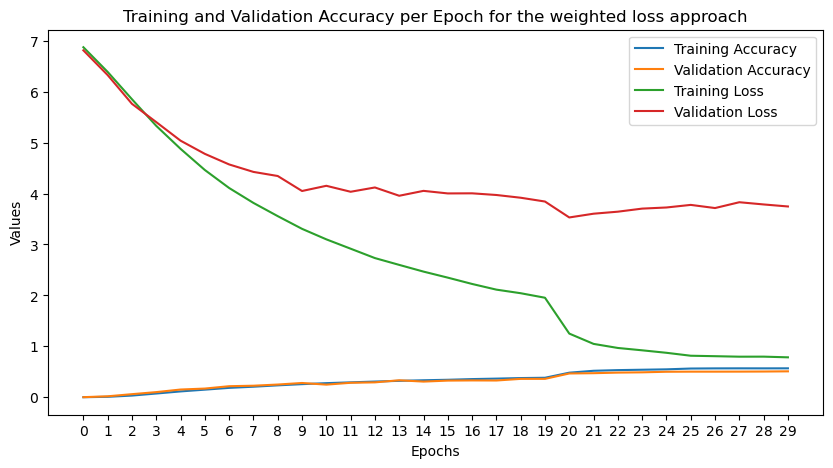

In [21]:
# read training progress data
df_epoch_acc = pd.read_csv('./results/epoch_acc_train_val_weighted_crossentropy.csv')

# visualize training progress data
plt.figure(figsize=(10, 5))

# plot the data
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_train'], label='Training Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_val'], label='Validation Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_train'], label='Training Loss')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_val'], label='Validation Loss')

# add titles and labels
plt.title('Training and Validation Accuracy per Epoch for the weighted loss approach')
plt.xlabel('Epochs')
plt.ylabel('Values')

# display the legend
plt.legend()

# set x-axis ticks to show integers only
plt.xticks(range(df_epoch_acc['epoch'].min(), df_epoch_acc['epoch'].max()+1))

# save the figure as a PNG file
plt.savefig('./results/training_weighted_crossentropy.png', format='png', dpi=300)

# save the figure as a SVG vector graphic
plt.savefig('./results/training_weighted_crossentropy.svg', format='svg')

plt.show()

The next code block calculates the final accuracy on the test set.

In [10]:
start_time = time.time()

filename = './results/resnet18_weighted_crossentropy/resnet18_weighted_crossentropy_weights_best_acc.tar'
model_name = 'resnet18'
        
# load the model
model = pytorch_models[model_name](num_classes=1081)

# Load model weights and set to evaluation mode
load_model(model, filename=filename, use_gpu=use_gpu)
model.eval()
if use_gpu and torch.cuda.is_available():
    model.cuda()

# collect softmax outputs
softmax_outputs = []
labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        if use_gpu and torch.cuda.is_available():
            inputs = inputs.cuda()

        outputs = model(inputs)
        softmax_outputs.append(outputs.cpu().numpy())
        labels.append(targets.cpu().numpy())

softmax_outputs = np.concatenate(softmax_outputs, axis=0)
labels = np.concatenate(labels, axis=0)

# convert averaged softmax outputs to predicted classes
_, predictions = torch.max(torch.tensor(softmax_outputs), 1)

# calculate accuracy
correct = (predictions.numpy() == labels).sum()
total = labels.size
average_accuracy = correct / total

# calculate per-class accuracy
cm = confusion_matrix(labels, predictions.numpy())
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# count classes with over 90% accuracy
count_over_90 = np.sum(per_class_accuracy > 0.9)
count_under_90 = len(per_class_accuracy) - count_over_90

# print results
print(f'Accuracy for the weighted crossentropy model: {average_accuracy}')
print(f'Number of classes with accuracy over 90%: {count_over_90}')
print(f'Number of classes with accuracy under 90%: {count_under_90}')

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Accuracy for the weighted crossentropy model: 0.5075034544811852
Number of classes with accuracy over 90%: 53
Number of classes with accuracy under 90%: 1028
total time taken: 0h 0m 46.01s


# Continued training of an existing model <a id="continued_training"></a>

Another way to improve the model is to use an existing model as a checkpoint and go through additional training cycles. To keep the code for this analysis relatively simple, the file path to the PlantNet-models is hard-coded in the *main.py* file. It is also possible to combine the other approaches mentioned above. 

This approach can be controlled by the additional boolean parameter *continue_training*. In the example below, data augmentation was used together with continued training, characterized by the parameters *threshold=1000* and *continue_training*.

In [45]:
start_time = time.time()

# execute command line call
root_folder = '../PlantNet-300K-dataset/images'
command = f'run main.py --lr=0.01 --batch_size=32 --mu=0.0001 --n_epochs=20 --epoch_decay 20 25 --k 1 3 5 10 --model=resnet18 --pretrained --seed=4 --image_size=256 --crop_size=224 --threshold=1000 --continue_training --root={root_folder} --save_name_xp=resnet18_continue_training'
get_ipython().run_line_magic('time', command)

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Seed:	 4


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



USING GPU
args.k :  [1, 3, 5, 10]


val:   0%|          | 0/973 [00:00<?, ?it/s]/home/paulb001/PlantNet-300K/epoch.py:79: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

epoch:   5%|▌         | 1/20 [07:00<2:13:10, 420.56s/it]


epoch 0 took 420.56
loss_train : 0.6413364213346997
loss_val : 1.188764945316462
acc_train : 0.8104139344262296 / topk_acc_train : {1: 0.8104139344262296, 3: 0.9482909836065574, 5: 0.9721270491803279, 10: 0.9875450819672131}
acc_val : 0.7104569702423035 / topk_acc_val : {1: 0.7104569702423035, 3: 0.8758917668230606, 5: 0.9166398868821903, 10: 0.9500931936499775} / avgk_acc_val : {1: 0.7209653576708015, 3: 0.9021466675236197, 5: 0.9367889967221544, 10: 0.9627546757503695}


epoch:  10%|█         | 2/20 [13:48<2:03:54, 413.05s/it]


epoch 1 took 407.78
loss_train : 0.6316095378507879
loss_val : 1.156650677721932
acc_train : 0.8138319672131148 / topk_acc_train : {1: 0.8138319672131148, 3: 0.9498524590163935, 5: 0.9733852459016393, 10: 0.9879057377049181}
acc_val : 0.7208689504466868 / topk_acc_val : {1: 0.7208689504466868, 3: 0.8811620284079954, 5: 0.9199177325020889, 10: 0.9525676457355872} / avgk_acc_val : {1: 0.7316986952889003, 3: 0.9069027572466096, 5: 0.9391027701009063, 10: 0.9648756346808921}


epoch:  15%|█▌        | 3/20 [20:37<1:56:28, 411.10s/it]


epoch 2 took 408.77
loss_train : 0.6095415599730183
loss_val : 1.1568331420114992
acc_train : 0.8192704918032787 / topk_acc_train : {1: 0.8192704918032787, 3: 0.9530450819672132, 5: 0.9747049180327869, 10: 0.988577868852459}
acc_val : 0.7258821261006492 / topk_acc_val : {1: 0.7258821261006492, 3: 0.8820618291663989, 5: 0.9208175332604923, 10: 0.9513143518220966} / avgk_acc_val : {1: 0.7355549842534868, 3: 0.9067420785397519, 5: 0.9381386978597597, 10: 0.9634937978019152}


epoch:  20%|██        | 4/20 [27:19<1:48:41, 407.62s/it]


epoch 3 took 402.30
loss_train : 0.5969747740155769
loss_val : 1.171124138735204
acc_train : 0.821844262295082 / topk_acc_train : {1: 0.821844262295082, 3: 0.9548319672131148, 5: 0.9762786885245902, 10: 0.9892418032786885}
acc_val : 0.7256250401696767 / topk_acc_val : {1: 0.7256250401696767, 3: 0.8837971592004628, 5: 0.9214602480879234, 10: 0.9511536731152388} / avgk_acc_val : {1: 0.7352657625811427, 3: 0.9060672279709493, 5: 0.9363712320843242, 10: 0.9629796259399704}


epoch:  25%|██▌       | 5/20 [34:22<1:43:18, 413.26s/it]


epoch 4 took 423.25
loss_train : 0.5899124153394248
loss_val : 1.179400802057221
acc_train : 0.8249098360655738 / topk_acc_train : {1: 0.8249098360655738, 3: 0.9555286885245902, 5: 0.9763811475409836, 10: 0.9895081967213115}
acc_val : 0.7158557747927244 / topk_acc_val : {1: 0.7158557747927244, 3: 0.8769201105469503, 5: 0.9176039591233369, 10: 0.9487434925123722} / avgk_acc_val : {1: 0.7266533838935664, 3: 0.9034963686612251, 5: 0.9353107526190629, 10: 0.9626582685262549}


epoch:  30%|███       | 6/20 [41:06<1:35:40, 410.01s/it]


epoch 5 took 403.70
loss_train : 0.5750215654491064
loss_val : 1.1913213550799178
acc_train : 0.8280614754098361 / topk_acc_train : {1: 0.8280614754098361, 3: 0.9575450819672131, 5: 0.9777868852459016, 10: 0.990516393442623}
acc_val : 0.7173982903785591 / topk_acc_val : {1: 0.7173982903785591, 3: 0.8783340831672987, 5: 0.9169612442959059, 10: 0.9493540715984318} / avgk_acc_val : {1: 0.7283887139276303, 3: 0.9017289028857896, 5: 0.9348287164984896, 10: 0.9614049746127643}


epoch:  35%|███▌      | 7/20 [47:56<1:28:51, 410.11s/it]


epoch 6 took 410.32
loss_train : 0.5731129825910688
loss_val : 1.170974534756117
acc_train : 0.8284549180327869 / topk_acc_train : {1: 0.8284549180327869, 3: 0.9579016393442623, 5: 0.9780450819672131, 10: 0.9905983606557377}
acc_val : 0.719133620412623 / topk_acc_val : {1: 0.719133620412623, 3: 0.8811620284079954, 5: 0.9196606465711163, 10: 0.9503181438395784} / avgk_acc_val : {1: 0.7318272382543866, 3: 0.9050710199884311, 5: 0.9364676393084388, 10: 0.9616941962851083}


epoch:  40%|████      | 8/20 [54:47<1:22:02, 410.21s/it]


epoch 7 took 410.42
loss_train : 0.5634910394813853
loss_val : 1.1546067417035868
acc_train : 0.831860655737705 / topk_acc_train : {1: 0.831860655737705, 3: 0.959077868852459, 5: 0.979172131147541, 10: 0.991061475409836}
acc_val : 0.7253036827559611 / topk_acc_val : {1: 0.7253036827559611, 3: 0.8817726074940548, 5: 0.9212995693810656, 10: 0.952503374252844} / avgk_acc_val : {1: 0.7361334275981747, 3: 0.9072562504016968, 5: 0.9384600552734752, 10: 0.963943698181117}


epoch:  45%|████▌     | 9/20 [1:01:27<1:14:39, 407.26s/it]


epoch 8 took 400.76
loss_train : 0.5531729727363897
loss_val : 1.205470482715302
acc_train : 0.8336557377049181 / topk_acc_train : {1: 0.8336557377049181, 3: 0.959983606557377, 5: 0.9793401639344262, 10: 0.9913647540983607}
acc_val : 0.7192621633781091 / topk_acc_val : {1: 0.7192621633781091, 3: 0.875570409409345, 5: 0.9163828009512179, 10: 0.9489684427019731} / avgk_acc_val : {1: 0.7301561797030658, 3: 0.8997686226621248, 5: 0.9329969792403111, 10: 0.9605051738543608}


epoch:  50%|█████     | 10/20 [1:08:10<1:07:38, 405.89s/it]


epoch 9 took 402.81
loss_train : 0.5505161126674879
loss_val : 1.2077734653105952
acc_train : 0.8340409836065574 / topk_acc_train : {1: 0.8340409836065574, 3: 0.9600040983606557, 5: 0.9794180327868852, 10: 0.9915819672131148}
acc_val : 0.7143132592068899 / topk_acc_val : {1: 0.7143132592068899, 3: 0.8766630246159779, 5: 0.9160935792788739, 10: 0.9486149495468861} / avgk_acc_val : {1: 0.7251108683077319, 3: 0.901985988816762, 5: 0.9329969792403111, 10: 0.9599588662510444}


epoch:  55%|█████▌    | 11/20 [1:14:54<1:00:48, 405.36s/it]


epoch 10 took 404.18
loss_train : 0.5434762829365473
loss_val : 1.1694847673729614
acc_train : 0.835860655737705 / topk_acc_train : {1: 0.835860655737705, 3: 0.9610737704918033, 5: 0.9803852459016393, 10: 0.9918688524590163}
acc_val : 0.726685519634938 / topk_acc_val : {1: 0.726685519634938, 3: 0.8834436660453757, 5: 0.9203997686226622, 10: 0.9515393020116975} / avgk_acc_val : {1: 0.7362619705636609, 3: 0.9054887846262614, 5: 0.9367568609807828, 10: 0.9622405038884247}


epoch:  60%|██████    | 12/20 [1:21:39<54:00, 405.07s/it]  


epoch 11 took 404.40
loss_train : 0.5395029366205976
loss_val : 1.194697735930789
acc_train : 0.8366844262295082 / topk_acc_train : {1: 0.8366844262295082, 3: 0.9618688524590164, 5: 0.9807049180327869, 10: 0.9919467213114754}
acc_val : 0.7200655569123979 / topk_acc_val : {1: 0.7200655569123979, 3: 0.8793624268911884, 5: 0.9170576515200206, 10: 0.9501896008740922} / avgk_acc_val : {1: 0.7306382158236391, 3: 0.9023716177132206, 5: 0.9335432868436275, 10: 0.9592518799408702}


epoch:  65%|██████▌   | 13/20 [1:28:17<47:00, 402.86s/it]


epoch 12 took 397.77
loss_train : 0.5343897788504927
loss_val : 1.2025744763544066
acc_train : 0.8384836065573771 / topk_acc_train : {1: 0.8384836065573771, 3: 0.9625368852459016, 5: 0.9812295081967213, 10: 0.9922991803278689}
acc_val : 0.7166270325856418 / topk_acc_val : {1: 0.7166270325856418, 3: 0.8759239025644322, 5: 0.9164470724339611, 10: 0.9489684427019731} / avgk_acc_val : {1: 0.7267819268590526, 3: 0.9000899800758404, 5: 0.9338003727745999, 10: 0.9599910019924159}


epoch:  70%|███████   | 14/20 [1:34:57<40:12, 402.14s/it]


epoch 13 took 400.48
loss_train : 0.522515564136684
loss_val : 1.203920317928732
acc_train : 0.8428483606557376 / topk_acc_train : {1: 0.8428483606557376, 3: 0.9639631147540983, 5: 0.982110655737705, 10: 0.992577868852459}
acc_val : 0.7241146603252137 / topk_acc_val : {1: 0.7241146603252137, 3: 0.8796516485635324, 5: 0.91766823060608, 10: 0.9496754290121473} / avgk_acc_val : {1: 0.7328877177196478, 3: 0.9010219165756154, 5: 0.9338646442573431, 10: 0.9599267305096728}


epoch:  75%|███████▌  | 15/20 [1:42:02<34:04, 408.94s/it]


epoch 14 took 424.68
loss_train : 0.5256753386191805
loss_val : 1.1962687382359563
acc_train : 0.8404344262295081 / topk_acc_train : {1: 0.8404344262295081, 3: 0.9635368852459016, 5: 0.9816065573770492, 10: 0.9923934426229508}
acc_val : 0.7244038819975577 / topk_acc_val : {1: 0.7244038819975577, 3: 0.880969213959766, 5: 0.9211710264155794, 10: 0.9514750305289543} / avgk_acc_val : {1: 0.7336911112539366, 3: 0.9050388842470596, 5: 0.935085802429462, 10: 0.9611478886817919}


epoch:  80%|████████  | 16/20 [1:48:43<27:06, 406.72s/it]


epoch 15 took 401.57
loss_train : 0.519777887776408
loss_val : 1.2215347077252934
acc_train : 0.8425819672131147 / topk_acc_train : {1: 0.8425819672131147, 3: 0.9645409836065574, 5: 0.9819180327868853, 10: 0.992766393442623}
acc_val : 0.7145060736551192 / topk_acc_val : {1: 0.7145060736551192, 3: 0.8747670158750562, 5: 0.9144225207275531, 10: 0.946815348030079} / avgk_acc_val : {1: 0.7255607686869336, 3: 0.8976797994729738, 5: 0.9302333054823575, 10: 0.959412558647728}


epoch:  85%|████████▌ | 17/20 [1:55:39<20:27, 409.31s/it]


epoch 16 took 415.34
loss_train : 0.5135448243232504
loss_val : 1.2216229058587502
acc_train : 0.8440532786885246 / topk_acc_train : {1: 0.8440532786885246, 3: 0.9647745901639344, 5: 0.9827008196721312, 10: 0.9930491803278688}
acc_val : 0.7211903078604024 / topk_acc_val : {1: 0.7211903078604024, 3: 0.8777556398226107, 5: 0.9156115431583006, 10: 0.9480686419435697} / avgk_acc_val : {1: 0.7305418085995244, 3: 0.9006684234205283, 5: 0.931422327913105, 10: 0.9585448936306961}


epoch:  90%|█████████ | 18/20 [2:02:37<13:44, 412.02s/it]


epoch 17 took 418.32
loss_train : 0.5137818719153874
loss_val : 1.1976433411823133
acc_train : 0.843922131147541 / topk_acc_train : {1: 0.843922131147541, 3: 0.9649959016393442, 5: 0.9828688524590163, 10: 0.9928975409836066}
acc_val : 0.7203869143261135 / topk_acc_val : {1: 0.7203869143261135, 3: 0.880037277459991, 5: 0.9169933800372775, 10: 0.9496432932707758} / avgk_acc_val : {1: 0.731216659168327, 3: 0.9019217173340189, 5: 0.9341217301883155, 10: 0.9608908027508195}


epoch:  95%|█████████▌| 19/20 [2:09:41<06:55, 415.63s/it]


epoch 18 took 424.03
loss_train : 0.504074079599251
loss_val : 1.2228800577452643
acc_train : 0.8469754098360656 / topk_acc_train : {1: 0.8469754098360656, 3: 0.9662459016393442, 5: 0.9834098360655738, 10: 0.993516393442623}
acc_val : 0.7223793302911499 / topk_acc_val : {1: 0.7223793302911499, 3: 0.8780769972363263, 5: 0.9160935792788739, 10: 0.948839899736487} / avgk_acc_val : {1: 0.7318593739957581, 3: 0.8995758082138955, 5: 0.9324828073783662, 10: 0.9576450928722926}


epoch: 100%|██████████| 20/20 [2:16:26<00:00, 409.31s/it]



epoch 19 took 404.63
loss_train : 0.5023240104859064
loss_val : 1.1938480951750474
acc_train : 0.8473196721311476 / topk_acc_train : {1: 0.8473196721311476, 3: 0.9662704918032787, 5: 0.9832745901639345, 10: 0.9933647540983607}
acc_val : 0.7176553763095315 / topk_acc_val : {1: 0.7176553763095315, 3: 0.8781412687190694, 5: 0.917314737450993, 10: 0.9488077639951153} / avgk_acc_val : {1: 0.7288064785654605, 3: 0.90256443216145, 5: 0.93566424577415, 10: 0.9611800244231634}



test:   0%|          | 0/973 [00:00<?, ?it/s]/home/paulb001/PlantNet-300K/epoch.py:154: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

test: 100%|██████████| 973/973 [00:48<00:00, 19.87it/s]

CPU times: user 57min 3s, sys: 16min 25s, total: 1h 13min 28s
Wall time: 2h 17min 21s
total time taken: 2h 17m 21.77s


In order to be able to compare training progress between different training cycles, the training data is renamed in the next code block.

In [46]:
# rename the file
current_file_path = './results/epoch_acc_train_val.csv'
new_file_path = './results/epoch_acc_train_val_continue_training.csv'
os.rename(current_file_path, new_file_path)

The code block below visualizes the training progress.

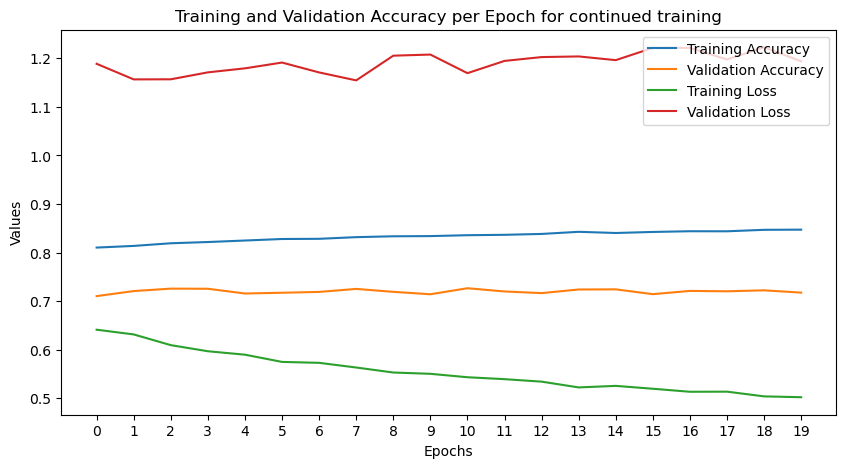

In [22]:
# read training progress data
df_epoch_acc = pd.read_csv('./results/epoch_acc_train_val_continue_training.csv')

# visualize training progress data
plt.figure(figsize=(10, 5))

# plot the data
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_train'], label='Training Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_val'], label='Validation Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_train'], label='Training Loss')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_val'], label='Validation Loss')

# add titles and labels
plt.title('Training and Validation Accuracy per Epoch for continued training')
plt.xlabel('Epochs')
plt.ylabel('Values')

# display the legend
plt.legend()

# set x-axis ticks to show integers only
plt.xticks(range(df_epoch_acc['epoch'].min(), df_epoch_acc['epoch'].max()+1))

# save the figure as a PNG file
plt.savefig('./results/training_continue_training.png', format='png', dpi=300)

# save the figure as a SVG vector graphic
plt.savefig('./results/training_continue_training.svg', format='svg')

plt.show()

The next code block calculates the final accuracy on the test set.

In [11]:
start_time = time.time()

filename = './results/resnet18_continue_training/resnet18_continue_training_weights_best_acc.tar'
model_name = 'resnet18'
        
# load the model
model = pytorch_models[model_name](num_classes=1081)

# Load model weights and set to evaluation mode
load_model(model, filename=filename, use_gpu=use_gpu)
model.eval()
if use_gpu and torch.cuda.is_available():
    model.cuda()

# collect softmax outputs
softmax_outputs = []
labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        if use_gpu and torch.cuda.is_available():
            inputs = inputs.cuda()

        outputs = model(inputs)
        softmax_outputs.append(outputs.cpu().numpy())
        labels.append(targets.cpu().numpy())

softmax_outputs = np.concatenate(softmax_outputs, axis=0)
labels = np.concatenate(labels, axis=0)

# convert averaged softmax outputs to predicted classes
_, predictions = torch.max(torch.tensor(softmax_outputs), 1)

# calculate accuracy
correct = (predictions.numpy() == labels).sum()
total = labels.size
average_accuracy = correct / total

# calculate per-class accuracy
cm = confusion_matrix(labels, predictions.numpy())
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# count classes with over 90% accuracy
count_over_90 = np.sum(per_class_accuracy > 0.9)
count_under_90 = len(per_class_accuracy) - count_over_90

# print results
print(f'Accuracy for the continued training model: {average_accuracy}')
print(f'Number of classes with accuracy over 90%: {count_over_90}')
print(f'Number of classes with accuracy under 90%: {count_under_90}')

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Accuracy for the continued training model: 0.7245412770333237
Number of classes with accuracy over 90%: 47
Number of classes with accuracy under 90%: 1034
total time taken: 0h 0m 47.07s


# Ensemble Method (averaged and weighted) <a id="ensemble"></a>

In addition to optimizing a model, another way to increase the accuracy of a prediction is to train multiple models and combine the models' predictions. A simple method of bringing the models together is an ensemble method, in which the predictions of the individual models are averaged into the final result.

Another ensemble approach is to not only average the results of the individual models, but also to weigh the model results based on the overall accuracy each model achieved on the test set. Both approaches are implemented in this chapter.

In [48]:
root_folder = '../PlantNet-300K-dataset/images'
batch_size=32
image_size=256
crop_size=224
num_workers=4
pretrained=True

All results shown previously are based on the ResNet-18 architecture. Models based on other architectures were also provided by PlantNet. The code block below shows for which architectures trained models are available.

These models can be found here: https://lab.plantnet.org/seafile/d/01ab6658dad6447c95ae/

In [4]:
# directory containing the model files
model_dir = './pre-trained-models'

# list all files in the directory
model_files = [filename for filename in os.listdir(model_dir) if filename.endswith('_weights_best_acc.tar')]
model_files.sort()

# extract model names from filenames
model_names = [filename.replace('_weights_best_acc.tar', '') for filename in model_files if filename.endswith('_weights_best_acc.tar')]

# print model names
for model_name in model_names:
    print(model_name)

alexnet
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
inception_resnet_v2
inception_v4
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
resnet101
resnet152
resnet18
resnet34
resnet50
shufflenet
squeezenet
vgg11
vit_base_patch16_224
wide_resnet101_2
wide_resnet50_2


The code block below determines the overall accuracy and the number of classes with over 90% accuracy for each individual model, for the simply averaged ensemble and for the weighted ensemble. In this way, the result of each model only needs to be calculated once to obtain all results for the individual models and for the two ensemble approaches.

In [50]:
start_time = time.time()

# variables to store predictions
combined_softmax_outputs_simple = None
combined_softmax_outputs_weighted = None
combined_labels = None
model_accuracies = {}
model_class_acc_dict = {}
model_acc_over_90 = {}
model_acc_under_90 = {}
use_gpu = True
model_weights = []  # stores the weights for the weighted average
weighted_outputs_list = []  # stores the individual model outputs for the weighted average

# load and evaluate each model
for filename in model_files:
    if filename.endswith('_weights_best_acc.tar'):
        model_name = filename.split('_weights_best_acc.tar')[0]
        
        # load the model
        if model_name in pytorch_models:
            model = pytorch_models[model_name](num_classes=1081)
        elif model_name in timm_models:
            model = timm.create_model(model_name, num_classes=1081)
        else:
            raise NotImplementedError
        
        # construct full path to model file
        full_model_path = os.path.join(model_dir, filename)
        
        # load model weights and set to evaluation mode
        load_model(model, filename=full_model_path, use_gpu=use_gpu)
        model.eval()
        if use_gpu and torch.cuda.is_available():
            model.cuda()

        # collect softmax outputs and calculate accuracies
        softmax_outputs = []
        labels = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                if use_gpu and torch.cuda.is_available():
                    inputs = inputs.cuda()
                
                outputs = model(inputs)
                softmax_outputs.append(outputs.cpu().numpy())
                labels.append(targets.cpu().numpy())
            
        softmax_outputs = np.concatenate(softmax_outputs, axis=0)
        labels = np.concatenate(labels, axis=0)
        
        # calculate and save accuracy for single model
        # convert softmax outputs to predicted classes
        _, predictions = torch.max(torch.tensor(softmax_outputs), 1)
        correct = (predictions.numpy() == labels).sum()
        total = labels.size
        average_accuracy = correct / total
        
        # calculate per-class accuracy
        cm = confusion_matrix(labels, predictions.numpy())
        per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
        
        # count classes with over 90% accuracy
        count_over_90 = np.sum(per_class_accuracy > 0.9)
        count_under_90 = len(per_class_accuracy) - count_over_90
        
        # save results
        model_accuracies[model_name] = average_accuracy
        model_class_acc_dict[model_name] = per_class_accuracy
        model_acc_over_90[model_name] = count_over_90
        model_acc_under_90[model_name] = count_under_90
        
        model_weights.append(average_accuracy)
        weighted_outputs_list.append(softmax_outputs)  
        
        # aggregate predictions for simple average
        if combined_softmax_outputs_simple is None:
            combined_softmax_outputs_simple = softmax_outputs
            combined_labels = labels
        else:
            combined_softmax_outputs_simple += softmax_outputs
            
        # aggregate predictions for weighted average
        if combined_softmax_outputs_weighted is None:
            combined_softmax_outputs_weighted = softmax_outputs * average_accuracy
        else:
            combined_softmax_outputs_weighted += softmax_outputs * average_accuracy
            
        print(f'{filename} integrated.')
        print(f'{filename} average Accuracy of: {average_accuracy}')
        print(f'{filename} number of classes with accuracy over 90%: {count_over_90}')
        print(f'{filename} number of classes with accuracy under 90%: {count_under_90}')
        print() # for output readability
    
# calculate results for simple average
# calculate accuracy for simple average
combined_softmax_outputs_simple /= len(model_files)
_, combined_predictions_simple = torch.max(torch.tensor(combined_softmax_outputs_simple), 1)
simple_correct = (combined_predictions_simple.numpy() == combined_labels).sum()
total = combined_labels.size
simple_accuracy = simple_correct / total

# calculate per-class accuracy for simple average
cm_simple = confusion_matrix(combined_labels, combined_predictions_simple.numpy())
per_class_accuracy_simple = cm_simple.diagonal() / cm_simple.sum(axis=1)

# count classes with over 90% accuracy for simple average
count_over_90_simple = np.sum(per_class_accuracy_simple > 0.9)
count_under_90_simple = len(per_class_accuracy_simple) - count_over_90_simple

# save results for simple average ensemble
model_accuracies['ensemble'] = simple_accuracy
model_class_acc_dict['ensemble'] = per_class_accuracy_simple
model_acc_over_90['ensemble'] = count_over_90_simple
model_acc_under_90['ensemble'] = count_under_90_simple

print(f'Average Accuracy for simple average ensemble of all models: {simple_accuracy}')
print(f'Number of classes with accuracy over 90% for simple average ensemble of all models: {count_over_90_simple}')
print(f'Number of classes with accuracy under 90%: for simple average ensemble of all models: {count_under_90_simple}')
print() # for readability

# calculate results for weighted average
# normalize the weights
total_weight = sum(model_weights)
normalized_weights = [w / total_weight for w in model_weights]

# apply normalized weights to the outputs
for weight, outputs in zip(normalized_weights, weighted_outputs_list):
    if combined_softmax_outputs_weighted is None:
        combined_softmax_outputs_weighted = outputs * weight
    else:
        combined_softmax_outputs_weighted += outputs * weight

# calculate accuracy for weighted average
_, combined_predictions_weighted = torch.max(torch.tensor(combined_softmax_outputs_weighted), 1)
weighted_correct = (combined_predictions_weighted.numpy() == combined_labels).sum()
total = combined_labels.size
weighted_accuracy = weighted_correct / total

# calculate per-class accuracy for weighted average
cm = confusion_matrix(combined_labels, combined_predictions_weighted.numpy())
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# count classes with over 90% accuracy for weighted average
count_over_90_weighted = np.sum(per_class_accuracy > 0.9)
count_under_90_weighted = len(per_class_accuracy) - count_over_90_weighted

# save results for weighted ensemble
model_accuracies['ensemble_weighted'] = weighted_accuracy
model_class_acc_dict['ensemble_weighted'] = per_class_accuracy
model_acc_over_90['ensemble_weighted'] = count_over_90_weighted
model_acc_under_90['ensemble_weighted'] = count_under_90_weighted

print(f'Average Accuracy for weighted ensemble of all models: {weighted_accuracy}')
print(f'Number of classes with accuracy over 90% for weighted ensemble of all models: {count_over_90_weighted}')
print(f'Number of classes with accuracy under 90%: for weighted ensemble of all models: {count_under_90_weighted}')

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

alexnet_weights_best_acc.tar integrated.
alexnet_weights_best_acc.tar average Accuracy of: 0.686911533146952
alexnet_weights_best_acc.tar number of classes with accuracy over 90%: 36
alexnet_weights_best_acc.tar number of classes with accuracy under 90%: 1045

densenet121_weights_best_acc.tar integrated.
densenet121_weights_best_acc.tar average Accuracy of: 0.8093126385809313
densenet121_weights_best_acc.tar number of classes with accuracy over 90%: 138
densenet121_weights_best_acc.tar number of classes with accuracy under 90%: 943

densenet161_weights_best_acc.tar integrated.
densenet161_weights_best_acc.tar average Accuracy of: 0.8084771361547608
densenet161_weights_best_acc.tar number of classes with accuracy over 90%: 153
densenet161_weights_best_acc.tar number of classes with accuracy under 90%: 928

densenet169_weights_best_acc.tar integrated.
densenet169_weights_best_acc.tar average Accuracy of: 0.8092805038722324
densenet169_weights_best_acc.tar number of classes with accuracy 

For a better overview the following code block prints the models sorted by overall accuracy. Both ensembles perform better than the individual models. The slightly more sophisticated weighted ensemble also slightly outperforms the simple, averaged ensemble.

In [51]:
sorted_models = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)

# print sorted models
for model, accuracy in sorted_models:
    print(f'Model: {model}, Accuracy test: {accuracy}')

Model: ensemble_weighted, Accuracy test: 0.8320318776310293
Model: ensemble, Accuracy test: 0.8317105305440406
Model: vit_base_patch16_224, Accuracy test: 0.8213631543430059
Model: efficientnet_b0, Accuracy test: 0.8108872393071757
Model: wide_resnet50_2, Accuracy test: 0.810340949259295
Model: efficientnet_b1, Accuracy test: 0.8097625245027154
Model: densenet121, Accuracy test: 0.8093126385809313
Model: densenet169, Accuracy test: 0.8092805038722324
Model: wide_resnet101_2, Accuracy test: 0.8091519650374369
Model: efficientnet_b2, Accuracy test: 0.8090234262026414
Model: densenet201, Accuracy test: 0.8087342138243517
Model: densenet161, Accuracy test: 0.8084771361547608
Model: resnet152, Accuracy test: 0.8083164626112664
Model: resnet50, Accuracy test: 0.8071596130981072
Model: resnet101, Accuracy test: 0.8070310742633118
Model: efficientnet_b3, Accuracy test: 0.806998939554613
Model: mobilenet_v3_large, Accuracy test: 0.7995115524277773
Model: mobilenet_v2, Accuracy test: 0.798643915

The following code block outputs the models sorted by number of classes with over 90% accuracy. The same theme occurs here: Both ensembles perform better than the individual models, and the weighted ensemble slightly outperforms the simple, averaged ensemble.

In [52]:
sorted_models = sorted(model_acc_over_90.items(), key=lambda x: x[1], reverse=True)

# print sorted models
for model, count in sorted_models:
    print(f'Model: {model}, Number of classes with accuracy > 0.9: {count}')

Model: ensemble_weighted, Number of classes with accuracy > 0.9: 197
Model: ensemble, Number of classes with accuracy > 0.9: 195
Model: vit_base_patch16_224, Number of classes with accuracy > 0.9: 173
Model: densenet201, Number of classes with accuracy > 0.9: 165
Model: efficientnet_b1, Number of classes with accuracy > 0.9: 158
Model: mobilenet_v3_large, Number of classes with accuracy > 0.9: 156
Model: efficientnet_b2, Number of classes with accuracy > 0.9: 155
Model: densenet161, Number of classes with accuracy > 0.9: 153
Model: efficientnet_b3, Number of classes with accuracy > 0.9: 152
Model: densenet169, Number of classes with accuracy > 0.9: 149
Model: efficientnet_b4, Number of classes with accuracy > 0.9: 146
Model: wide_resnet101_2, Number of classes with accuracy > 0.9: 146
Model: wide_resnet50_2, Number of classes with accuracy > 0.9: 146
Model: resnet101, Number of classes with accuracy > 0.9: 144
Model: efficientnet_b0, Number of classes with accuracy > 0.9: 143
Model: re

# Mixture of Experts <a id="mixture_of_experts"></a>

In addition to combining all models in one ensemble, *Mixture of Experts* is another possible approach to combine individual models. In this approach, traditionally, different experts are trained on different subsets of a dataset. In addition to the experts, a *Router*, sometimes also called a *Gating Network*, is trained, which determines which of the experts makes the decision for a request. It is also possible for a router to determine a mix of different experts for a prediction by dynamically weighing the contribution of each individual expert based on the specific input.

In this implementation, the existing models are used as experts. Only an additional router is trained that weighs the results from the individual models, so the general process is in line with the Mixture of Experts approach. The aim here is to show how already existing models can be leveraged by this approach.

As can be seen in the code block below, only the first 5 models from model_files are used for the router. The reason for this is that a *CUDA out of memory error* occurred when using all models. The code would need additional optimization for better memory handling. This optimization is not part of this Notebook. Additionally, as the main goal is to highlight the main idea behind Mixture of Experts, compute and training time were saved by not using more models as experts. The following code is sufficient to show how the Mixture of Experts approach generally works.

The code block below creates a list of the trained models that are going to be used. The models are set to evaluation mode as no additional training is performed on these models. 

In [15]:
# create a list of all trained models 
trained_models = [] # list to store models
use_gpu = True

for filename in model_files[:5]:
    model_name = filename.split('_weights_best_acc.tar')[0]
    
    # load the model
    if model_name in pytorch_models:
        model = pytorch_models[model_name](num_classes=1081)
    elif model_name in timm_models:
        model = timm.create_model(model_name, num_classes=1081)
    else:
        raise NotImplementedError
    
    # construct full path to model file
    full_model_path = os.path.join(model_dir, filename)
        
    # Load model weights and set to evaluation mode
    model.load_state_dict(torch.load(full_model_path)['model'])
    model.eval()
    
    if use_gpu and torch.cuda.is_available():
        model.cuda()
    
    trained_models.append(model)

The router is defined in the code block below. There are multiple ways to implement a router. As this dataset contains image data and the Mixture of Experts approach is mainly used in LLMs (Large Language Models), an existing image processing architecture in the form of ResNet-50 was used as a basis to process the image data. Only the last layer was replaced by a softmax layer corresponding to the number of trained models in order not to determine the classes directly, but to enable routing to the expert models. Additionally a dropout layer was used as the router was strongly overfitted. As will be seen later, the router is still overfitting. Additional measures should be taken to minimize overfitting, but these will not be part of this project.

For other ways of implementing a router and references to papers refer to the main anaylsis pdf.

In [19]:
from torchvision.models.resnet import ResNet50_Weights
import torchvision.models as models

class ImageRouter(nn.Module):
    def __init__(self, num_experts):
        super(ImageRouter, self).__init__()
        
        # load the pretrained ResNet-50 model
        self.feature_extractor = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        in_features = self.feature_extractor.fc.in_features
        
        # replace the final layer with an identity layer since we just want the features
        self.feature_extractor.fc = nn.Identity()
        
        # add dropout as model was overfitting
        self.dropout = nn.Dropout(0.5)
        
        # router layers
        self.router_fc = nn.Linear(in_features, num_experts)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # extract features from the image
        features = self.feature_extractor(x)
        
        # determine the weights for each expert model
        expert_weights = self.softmax(self.router_fc(features))
        return expert_weights

In [20]:
router = ImageRouter(num_experts=len(trained_models)).cuda()
optimizer = torch.optim.Adam(list(router.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

# set expert models to eval as they are not trained
for model in trained_models:
    model.eval().cuda()

The following code block defines the training function for the router. During the training every input is given to all experts. Based on the experts' results, the router learns the weights of each input for each expert. Note that the training routine is simpler as for the expert models as additional optimization strategies like learning rate decay are not implemented.

In [23]:
def train_router(router, experts, train_loader, val_loader, optimizer, criterion, num_epochs):
    val_accuracies = []
    for epoch in range(num_epochs):
        t = time.time()
        router.train()
        total_loss, total_accuracy = 0, 0
        num_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            num_samples += labels.size(0)

            optimizer.zero_grad()

            # obtain weights for each expert from the router
            weights = router(inputs)

            # gather expert predictions and compute weighted sum
            expert_outputs = torch.stack([model(inputs) for model in experts], dim=0).permute(1, 0, 2)
            combined_output = torch.einsum('bec,be->bc', expert_outputs, weights)

            loss = criterion(combined_output, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(combined_output.data, 1)
            total_accuracy += (predicted == labels).sum().item()

        loss_train = total_loss / len(train_loader)
        acc_train = total_accuracy / num_samples

        # validation phase
        router.eval()
        total_val_loss, total_val_accuracy = 0, 0
        num_val_samples = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.cuda(), labels.cuda()
                num_val_samples += labels.size(0)

                # obtain weights for each expert from the router
                weights = router(inputs)

                # gather expert predictions and compute weighted sum
                expert_outputs = torch.stack([model(inputs) for model in experts], dim=0).permute(1, 0, 2)
                combined_output = torch.einsum('bec,be->bc', expert_outputs, weights)

                loss_val = criterion(combined_output, labels)
                total_val_loss += loss_val.item()
                _, val_predicted = torch.max(combined_output.data, 1)
                total_val_accuracy += (val_predicted == labels).sum().item()

        loss_val = total_val_loss / len(val_loader)
        acc_val = total_val_accuracy / num_val_samples
        
        # save epoch results in a csv for later visualization
        import csv
        val_accuracies.append((epoch, loss_train, acc_train, loss_val, acc_val))
        with open('./results/epoch_acc_train_val.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['epoch', 'loss_train', 'acc_train', 'loss_val', 'acc_val']) # header row
            writer.writerows(val_accuracies)
        
        # print training and validation progress
        print(f'epoch {epoch+1} took {time.time()-t:.2f} seconds.')
        print(f'Epoch {epoch+1}: Train Loss {loss_train:.4f}, Train Acc {acc_train * 100:.2f}%, '
              f'Val Loss {loss_val:.4f}, Val Acc {acc_val * 100:.2f}%')

In the code block the router is trained.

In [24]:
start_time = time.time()

train_router(router, trained_models, train_loader, val_loader, optimizer, criterion, num_epochs=15)

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

epoch 1 took 2747.86 seconds.
Epoch 1: Train Loss 0.0449, Train Acc 99.01%, Val Loss 1.0707, Val Acc 76.88%
epoch 2 took 2756.10 seconds.
Epoch 2: Train Loss 0.0448, Train Acc 99.00%, Val Loss 1.0848, Val Acc 76.69%
epoch 3 took 2752.48 seconds.
Epoch 3: Train Loss 0.0451, Train Acc 98.98%, Val Loss 1.0572, Val Acc 77.12%
epoch 4 took 2745.87 seconds.
Epoch 4: Train Loss 0.0448, Train Acc 99.00%, Val Loss 1.1018, Val Acc 76.44%
epoch 5 took 2745.79 seconds.
Epoch 5: Train Loss 0.0449, Train Acc 99.00%, Val Loss 1.1050, Val Acc 76.54%
epoch 6 took 2753.23 seconds.
Epoch 6: Train Loss 0.0447, Train Acc 99.00%, Val Loss 1.0615, Val Acc 77.14%
epoch 7 took 2754.89 seconds.
Epoch 7: Train Loss 0.0449, Train Acc 98.99%, Val Loss 1.0290, Val Acc 77.53%
epoch 8 took 2757.77 seconds.
Epoch 8: Train Loss 0.0449, Train Acc 98.99%, Val Loss 1.0781, Val Acc 76.81%
epoch 9 took 2759.00 seconds.
Epoch 9: Train Loss 0.0446, Train Acc 99.03%, Val Loss 1.0660, Val Acc 77.07%
epoch 10 took 2756.30 second

KeyboardInterrupt: 

The traning was interrupted as no changes are expected in additional training epochs.

In order to be able to compare training progress between different training cycles, the training data is renamed in the next code block.

In [25]:
# rename the file
current_file_path = './results/epoch_acc_train_val.csv'
new_file_path = './results/epoch_acc_train_val_router.csv'
os.rename(current_file_path, new_file_path)

The code block below visualizes the training progress.

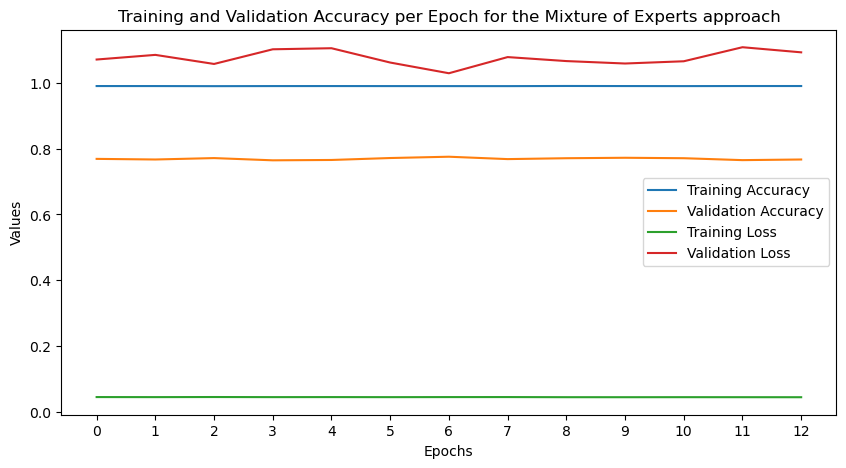

In [16]:
# read training progress data
df_epoch_acc = pd.read_csv('./results/epoch_acc_train_val_router.csv')

# visualize training progress data
plt.figure(figsize=(10, 5))

# plot the data
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_train'], label='Training Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['acc_val'], label='Validation Accuracy')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_train'], label='Training Loss')
plt.plot(df_epoch_acc['epoch'], df_epoch_acc['loss_val'], label='Validation Loss')

# add titles and labels
plt.title('Training and Validation Accuracy per Epoch for the Mixture of Experts approach')
plt.xlabel('Epochs')
plt.ylabel('Values')

# display the legend
plt.legend()

# set x-axis ticks to show integers only
plt.xticks(range(df_epoch_acc['epoch'].min(), df_epoch_acc['epoch'].max()+1))

# save the figure as a PNG file
plt.savefig('./results/training_router.png', format='png', dpi=300)

# save the figure as a SVG vector graphic
plt.savefig('./results/training_router.svg', format='svg')

plt.show()

In the below code block the router accuracy is determined based on the test set.

In [27]:
# variables to store predictions
model_accuracies = {}
model_class_acc_dict = {}
model_acc_over_90 = {}
model_acc_under_90 = {}

In [28]:
start_time = time.time()

# set the router to evaluation mode
router.eval()  

total_test_loss, total_test_accuracy = 0, 0
num_test_samples = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        if use_gpu and torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()

        # obtain weights for each expert from the router
        weights = router(inputs)

        # gather expert predictions and compute weighted sum
        expert_outputs = torch.stack([model(inputs) for model in trained_models], dim=0).permute(1, 0, 2)
        combined_output = torch.einsum('bec,be->bc', expert_outputs, weights)

        _, predicted = torch.max(combined_output.data, 1)
        total_test_accuracy += (predicted == targets).sum().item()

        # collect all labels and predictions for confusion matrix
        all_labels.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# calculate accuracy
total = len(all_labels)
accuracy_router = total_test_accuracy / total

# calculate per-class accuracy
cm = confusion_matrix(all_labels, all_predictions)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# count classes with over 90% accuracy for weighted average
count_over_90_router = np.sum(per_class_accuracy > 0.9)
count_under_90_router = len(per_class_accuracy) - count_over_90_router
    
# save results for the router
model_accuracies['router'] = accuracy_router
model_class_acc_dict['router'] = per_class_accuracy
model_acc_over_90['router'] = count_over_90_router
model_acc_under_90['router'] = count_under_90_router

print(f'Average Accuracy for the Router: {accuracy_router}')
print(f'Number of classes with accuracy over 90% for the Router: {count_over_90_router}')
print(f'Number of classes with accuracy under 90%: for the Router: {count_under_90_router}')

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

Average Accuracy for the Router: 0.7752177126514348
Number of classes with accuracy over 90% for the Router: 107
Number of classes with accuracy under 90%: for the Router: 974
total time taken: 0h 1m 43.06s


For a fair comparison with the ensemble methods, the two ensembles must be calculated based on the same selection of the models that were used for training and evaluating the router.

In [29]:
start_time = time.time()

# variables to store predictions
combined_softmax_outputs_simple = None
combined_softmax_outputs_weighted = None
combined_labels = None
use_gpu = True
model_weights = []  # stores the weights for the weighted average
weighted_outputs_list = []  # stores the individual model outputs for the weighted average

# Load and evaluate each model
for filename in model_files[:5]:
    if filename.endswith('_weights_best_acc.tar'):
        model_name = filename.split('_weights_best_acc.tar')[0]
        
        # load the model
        if model_name in pytorch_models:
            model = pytorch_models[model_name](num_classes=1081)
        elif model_name in timm_models:
            model = timm.create_model(model_name, num_classes=1081)
        else:
            raise NotImplementedError
        
        # construct full path to model file
        full_model_path = os.path.join(model_dir, filename)
        
        # load model weights and set to evaluation mode
        load_model(model, filename=full_model_path, use_gpu=use_gpu)
        model.eval()
        if use_gpu and torch.cuda.is_available():
            model.cuda()

        # collect softmax outputs and calculate accuracies
        softmax_outputs = []
        labels = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                if use_gpu and torch.cuda.is_available():
                    inputs = inputs.cuda()
                
                outputs = model(inputs)
                softmax_outputs.append(outputs.cpu().numpy())
                labels.append(targets.cpu().numpy())
            
        softmax_outputs = np.concatenate(softmax_outputs, axis=0)
        labels = np.concatenate(labels, axis=0)
        
        # calculate and save accuracy for single model
        # convert softmax outputs to predicted classes
        _, predictions = torch.max(torch.tensor(softmax_outputs), 1)
        correct = (predictions.numpy() == labels).sum()
        total = labels.size
        average_accuracy = correct / total
        
        # store individual results
        model_weights.append(average_accuracy)
        weighted_outputs_list.append(softmax_outputs)  
        
        # aggregate predictions for simple average
        if combined_softmax_outputs_simple is None:
            combined_softmax_outputs_simple = softmax_outputs
            combined_labels = labels
        else:
            combined_softmax_outputs_simple += softmax_outputs
            
        # aggregate predictions for weighted average
        if combined_softmax_outputs_weighted is None:
            combined_softmax_outputs_weighted = softmax_outputs * average_accuracy
        else:
            combined_softmax_outputs_weighted += softmax_outputs * average_accuracy
            
        print(f'{filename} integrated.')
    
# calculate results for simple average
# calculate accuracy for simple average
combined_softmax_outputs_simple /= len(model_files)
_, combined_predictions_simple = torch.max(torch.tensor(combined_softmax_outputs_simple), 1)
simple_correct = (combined_predictions_simple.numpy() == combined_labels).sum()
total = combined_labels.size
simple_accuracy = simple_correct / total

# calculate per-class accuracy for simple average
cm_simple = confusion_matrix(combined_labels, combined_predictions_simple.numpy())
per_class_accuracy_simple = cm_simple.diagonal() / cm_simple.sum(axis=1)

# count classes with over 90% accuracy for simple average
count_over_90_simple = np.sum(per_class_accuracy_simple > 0.9)
count_under_90_simple = len(per_class_accuracy_simple) - count_over_90_simple

# save results for simple average ensemble
model_accuracies['ensemble_small'] = simple_accuracy
model_class_acc_dict['ensemble_small'] = per_class_accuracy_simple
model_acc_over_90['ensemble_small'] = count_over_90_simple
model_acc_under_90['ensemble_small'] = count_under_90_simple

print(f'Average Accuracy for simple average ensemble of the first 10 models: {simple_accuracy}')
print(f'Number of classes with accuracy over 90% for simple average ensemble of the first 10 models: {count_over_90_simple}')
print(f'Number of classes with accuracy under 90%: for simple average ensemble of the first 10 models: {count_under_90_simple}')
print() # for readability

# calculate results for weighted average
# normalize the weights
total_weight = sum(model_weights)
normalized_weights = [w / total_weight for w in model_weights]

# apply normalized weights to the outputs
for weight, outputs in zip(normalized_weights, weighted_outputs_list):
    if combined_softmax_outputs_weighted is None:
        combined_softmax_outputs_weighted = outputs * weight
    else:
        combined_softmax_outputs_weighted += outputs * weight

# calculate accuracy for weighted average
_, combined_predictions_weighted = torch.max(torch.tensor(combined_softmax_outputs_weighted), 1)
weighted_correct = (combined_predictions_weighted.numpy() == combined_labels).sum()
total = combined_labels.size
weighted_accuracy = weighted_correct / total

# calculate per-class accuracy for weighted average
cm = confusion_matrix(combined_labels, combined_predictions_weighted.numpy())
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# count classes with over 90% accuracy for weighted average
count_over_90_weighted = np.sum(per_class_accuracy > 0.9)
count_under_90_weighted = len(per_class_accuracy) - count_over_90_weighted

# save results for weighted ensemble
model_accuracies['ensemble_small_weighted'] = weighted_accuracy
model_class_acc_dict['ensemble_small_weighted'] = per_class_accuracy
model_acc_over_90['ensemble_small_weighted'] = count_over_90_weighted
model_acc_under_90['ensemble_small_weighted'] = count_under_90_weighted

print(f'Average Accuracy for weighted ensemble of the first 5 models: {weighted_accuracy}')
print(f'Number of classes with accuracy over 90% for weighted ensemble of the first 5 models: {count_over_90_weighted}')
print(f'Number of classes with accuracy under 90%: for weighted ensemble of the first 5 models: {count_under_90_weighted}')

# print time taken in hour, minutes and seconds
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'total time taken: {int(hours)}h {int(minutes)}m {seconds:.2f}s')

alexnet_weights_best_acc.tar integrated.
densenet121_weights_best_acc.tar integrated.
densenet161_weights_best_acc.tar integrated.
densenet169_weights_best_acc.tar integrated.
densenet201_weights_best_acc.tar integrated.
Average Accuracy for simple average ensemble of the first 10 models: 0.821331019634307
Number of classes with accuracy over 90% for simple average ensemble of the first 10 models: 177
Number of classes with accuracy under 90%: for simple average ensemble of the first 10 models: 904

Average Accuracy for weighted ensemble of the first 5 models: 0.8232269674475401
Number of classes with accuracy over 90% for weighted ensemble of the first 5 models: 178
Number of classes with accuracy under 90%: for weighted ensemble of the first 5 models: 903
total time taken: 0h 4m 4.44s


In [30]:
sorted_models = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)

# print sorted models
for model, accuracy in sorted_models:
    print(f'Model: {model}, Accuracy test: {accuracy}')

Model: ensemble_small_weighted, Accuracy test: 0.8232269674475401
Model: ensemble_small, Accuracy test: 0.821331019634307
Model: router, Accuracy test: 0.7752177126514348


In [31]:
sorted_models = sorted(model_acc_over_90.items(), key=lambda x: x[1], reverse=True)

# print sorted models
for model, count in sorted_models:
    print(f'Model: {model}, Number of classes with accuracy > 0.9: {count}')

Model: ensemble_small_weighted, Number of classes with accuracy > 0.9: 178
Model: ensemble_small, Number of classes with accuracy > 0.9: 177
Model: router, Number of classes with accuracy > 0.9: 107


As the router is not fully optimized, for example because of the overfitting issue and because additional measures like load-balancing are not implemented, the router performs worse than the ensemble methods. The accuracy of the Mixture of Experts approach is even below the accuracy when using the ResNet-50 architecture to directly classify the images (accuracy of the trained ResNet-50 model: 80.7%).

In real world applications, for the specific scenario that models are already trained, a business decision has to be made if the implementation costs in time and compute is worthwhile given that a relatively simple ensemble approach, even with just a few of all available models, already provides quite satisfying results given the skewed nataure of the dataset.

For references to additional papers, further thoughts on optimizing this approach and my conclusion please refer to the final analysis pdf. 